In [109]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime
from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import gamma, poisson
import epyestim
import epyestim.covid19 as covid19
import epyestim.deconvolution as deconvolution
import epyestim.bootstrap as bootstrap
import epyestim.smoothen as smoothen
import os
from functions import _synthetic_infections as sim_inf
import functions
import scipy.linalg as la

In [110]:
UIUC_data = pd.read_csv("illinois_shield_covid_data_Updated.csv", parse_dates = [0])

# We only need aggregated daily positive cases and daily tests.
del UIUC_data["undergradCases"]
del UIUC_data["undergradTests"]
del UIUC_data["gradCases"]
del UIUC_data["gradTests"]
del UIUC_data["facStaffCases"]
del UIUC_data["facStaffTests"]

UIUC_data.rename(columns={"_time":"Date"},inplace= True)
UIUC_data.rename(columns={"totalNewCases":"Cases"},inplace= True)
UIUC_data.rename(columns={"totalNewTests":"Tests"},inplace= True)
UIUC_data = UIUC_data.loc[: 260]

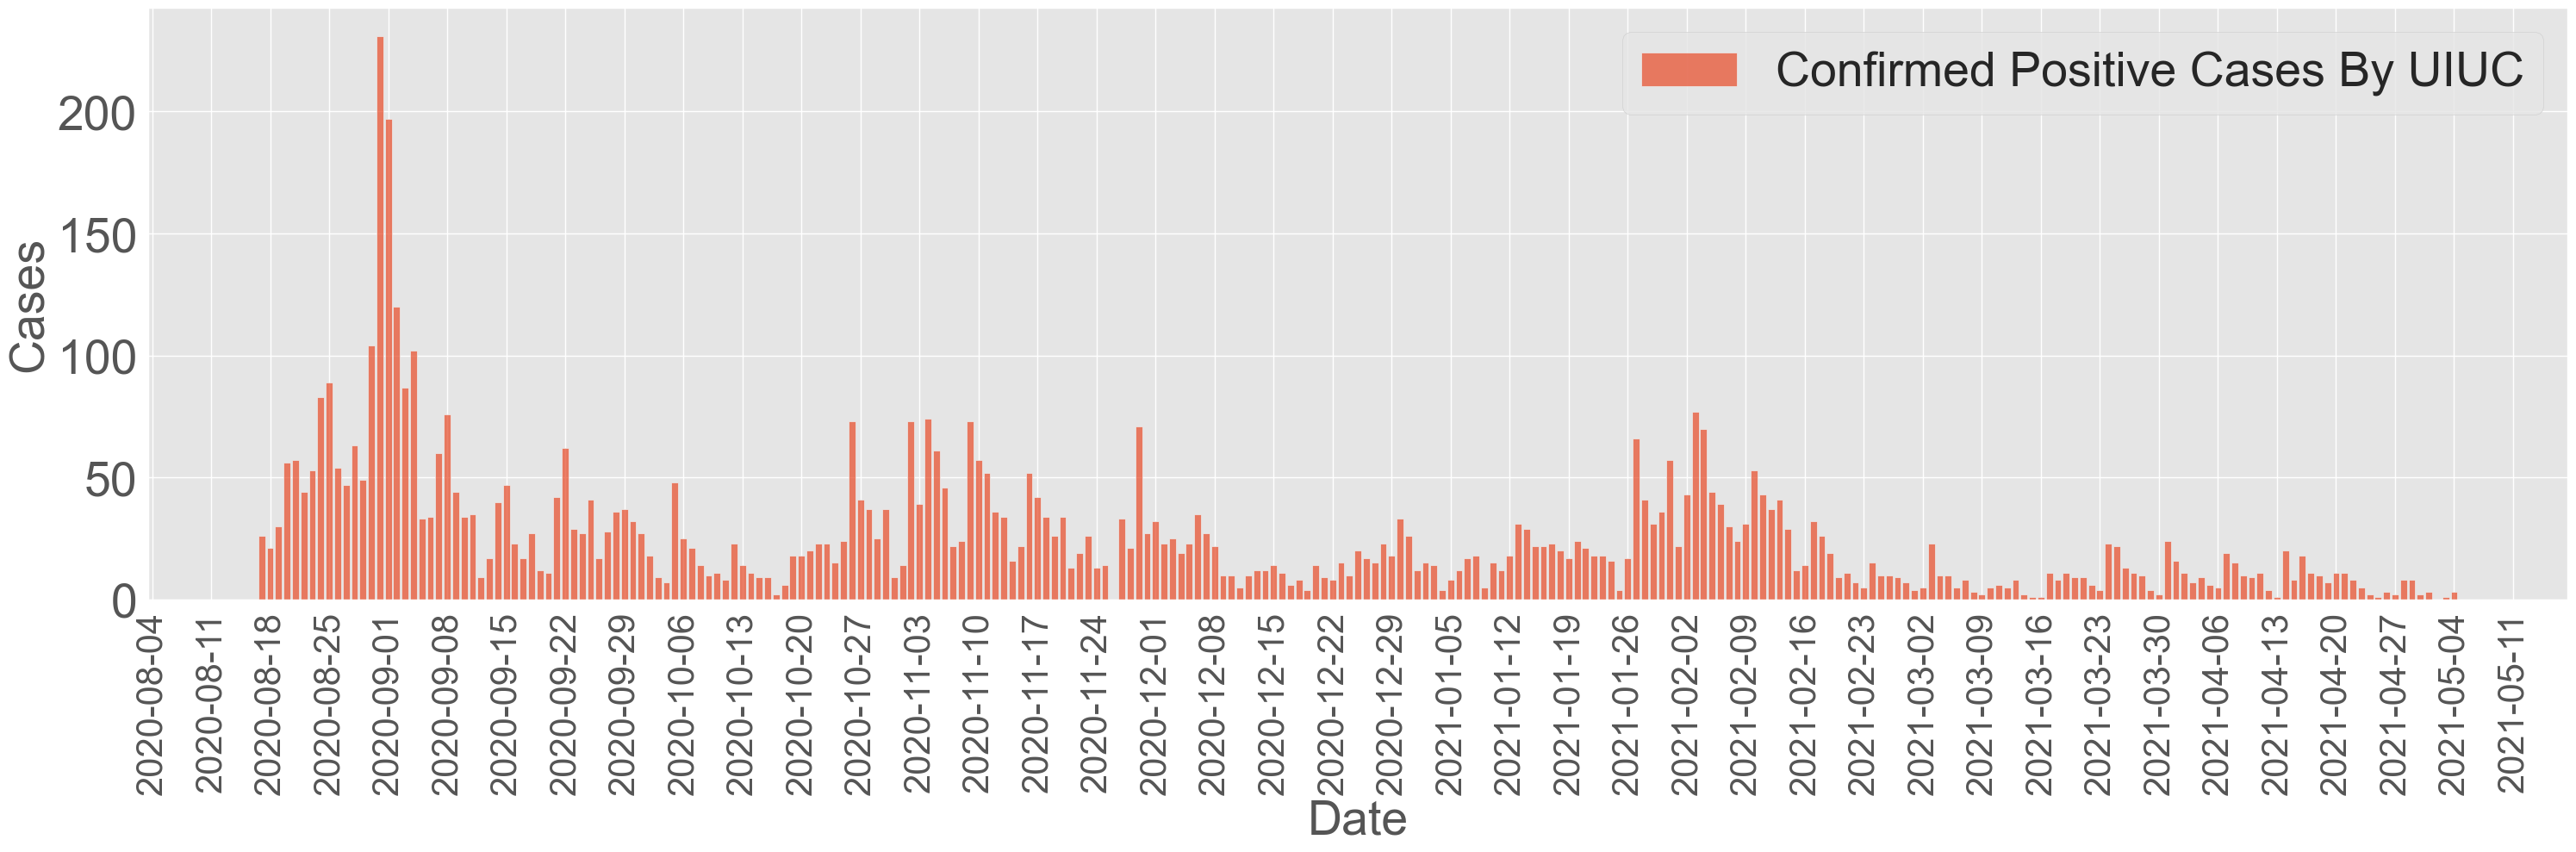

In [111]:
plt.style.use('ggplot')
fig, uiuc = plt.subplots(figsize=(30,10))
uiuc.bar(UIUC_data.Date, UIUC_data.Cases, color=(232/255, 74/255, 39/255, 0.7), label = 'Confirmed Positive Cases By UIUC')
uiuc.xaxis.set_major_locator(mdates.WeekdayLocator())
uiuc.legend(fontsize = 40)
uiuc.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
uiuc.tick_params(axis='x', rotation=90)
plt.xticks(fontsize = 30)
plt.yticks(fontsize = 40)
#uiuc.set_title('Confirmed Positive Cases During Fall 2020 at UIUC', fontsize = 20)
uiuc.set_ylabel('Cases')
uiuc.set_xlabel('Date')
uiuc.xaxis.label.set_size(40)
uiuc.yaxis.label.set_size(40)
plt.gcf().set_size_inches(30, 10)

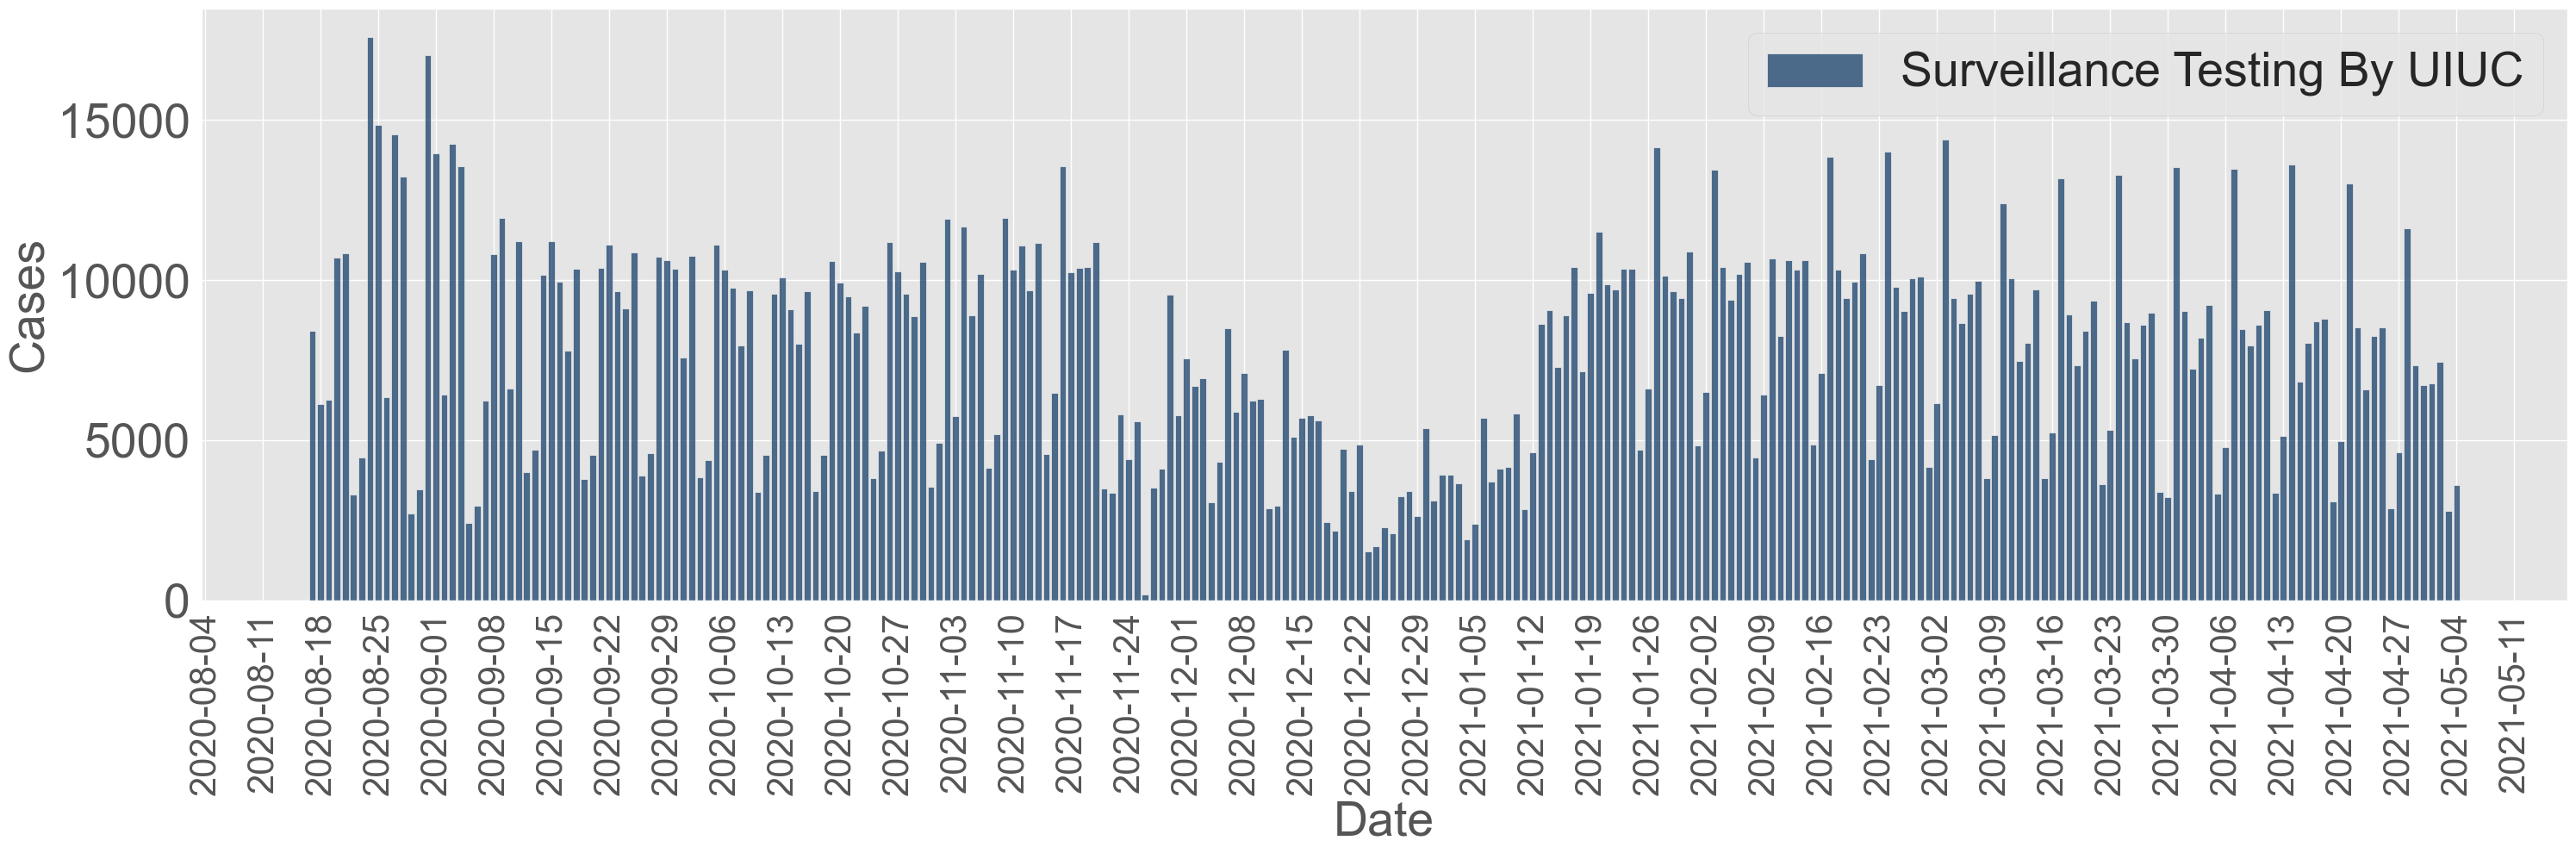

In [112]:
plt.style.use('ggplot')
fig, uiuc = plt.subplots(figsize=(30,10))
uiuc.bar(UIUC_data.Date, UIUC_data.Tests, color=(10/255, 52/255, 99/255, 0.7), label = 'Surveillance Testing By UIUC')
uiuc.xaxis.set_major_locator(mdates.WeekdayLocator())
uiuc.legend(fontsize = 40)
uiuc.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
uiuc.tick_params(axis='x', rotation=90)
plt.xticks(fontsize = 30)
plt.yticks(fontsize = 40)
#uiuc.set_title('Confirmed Positive Cases During Fall 2020 at UIUC', fontsize = 20)
uiuc.set_ylabel('Cases')
uiuc.set_xlabel('Date')
uiuc.xaxis.label.set_size(40)
uiuc.yaxis.label.set_size(40)
plt.gcf().set_size_inches(30, 10)

In [113]:
# Update infection profile
serial_UIUC = np.array([0.0000000001,0.0000000001, 0.148, 1.0, 0.823, 0.426, 0.202, 0.078, 0.042, 0.057, 0.009])
serial_UIUC_U = serial_UIUC / np.sum(serial_UIUC)

In [114]:
# U of Illinois tests everyone twice a week during Fall 2020
Ctrl_in = 2/7;
serial_UIUC_New = serial_UIUC-serial_UIUC
serial_UIUC_New[0]= serial_UIUC[0]
serial_UIUC_New[1]= serial_UIUC[1]

for x in range(2,len(serial_UIUC_New)):
    serial_UIUC_New [x] = (1-Ctrl_in)**(x-1)*serial_UIUC[x]
    
serial_UIUC_New = np.delete(serial_UIUC_New, [0])
serial_UIUC_New_U = serial_UIUC_New / np.sum(serial_UIUC_New)

In [115]:
# Preprocessing data for estimating the effective reproduction number
del UIUC_data["Tests"]
UIUC_data.set_index('Date', inplace=True)
UIUC_Total_Confirm = UIUC_data.squeeze()

In [116]:
# estimating the effective reproduction number using epyestim
UIUC_R= covid19.r_covid(UIUC_Total_Confirm,gt_distribution=serial_UIUC_New_U,smoothing_window=21, r_window_size=7)

<Figure size 640x480 with 0 Axes>

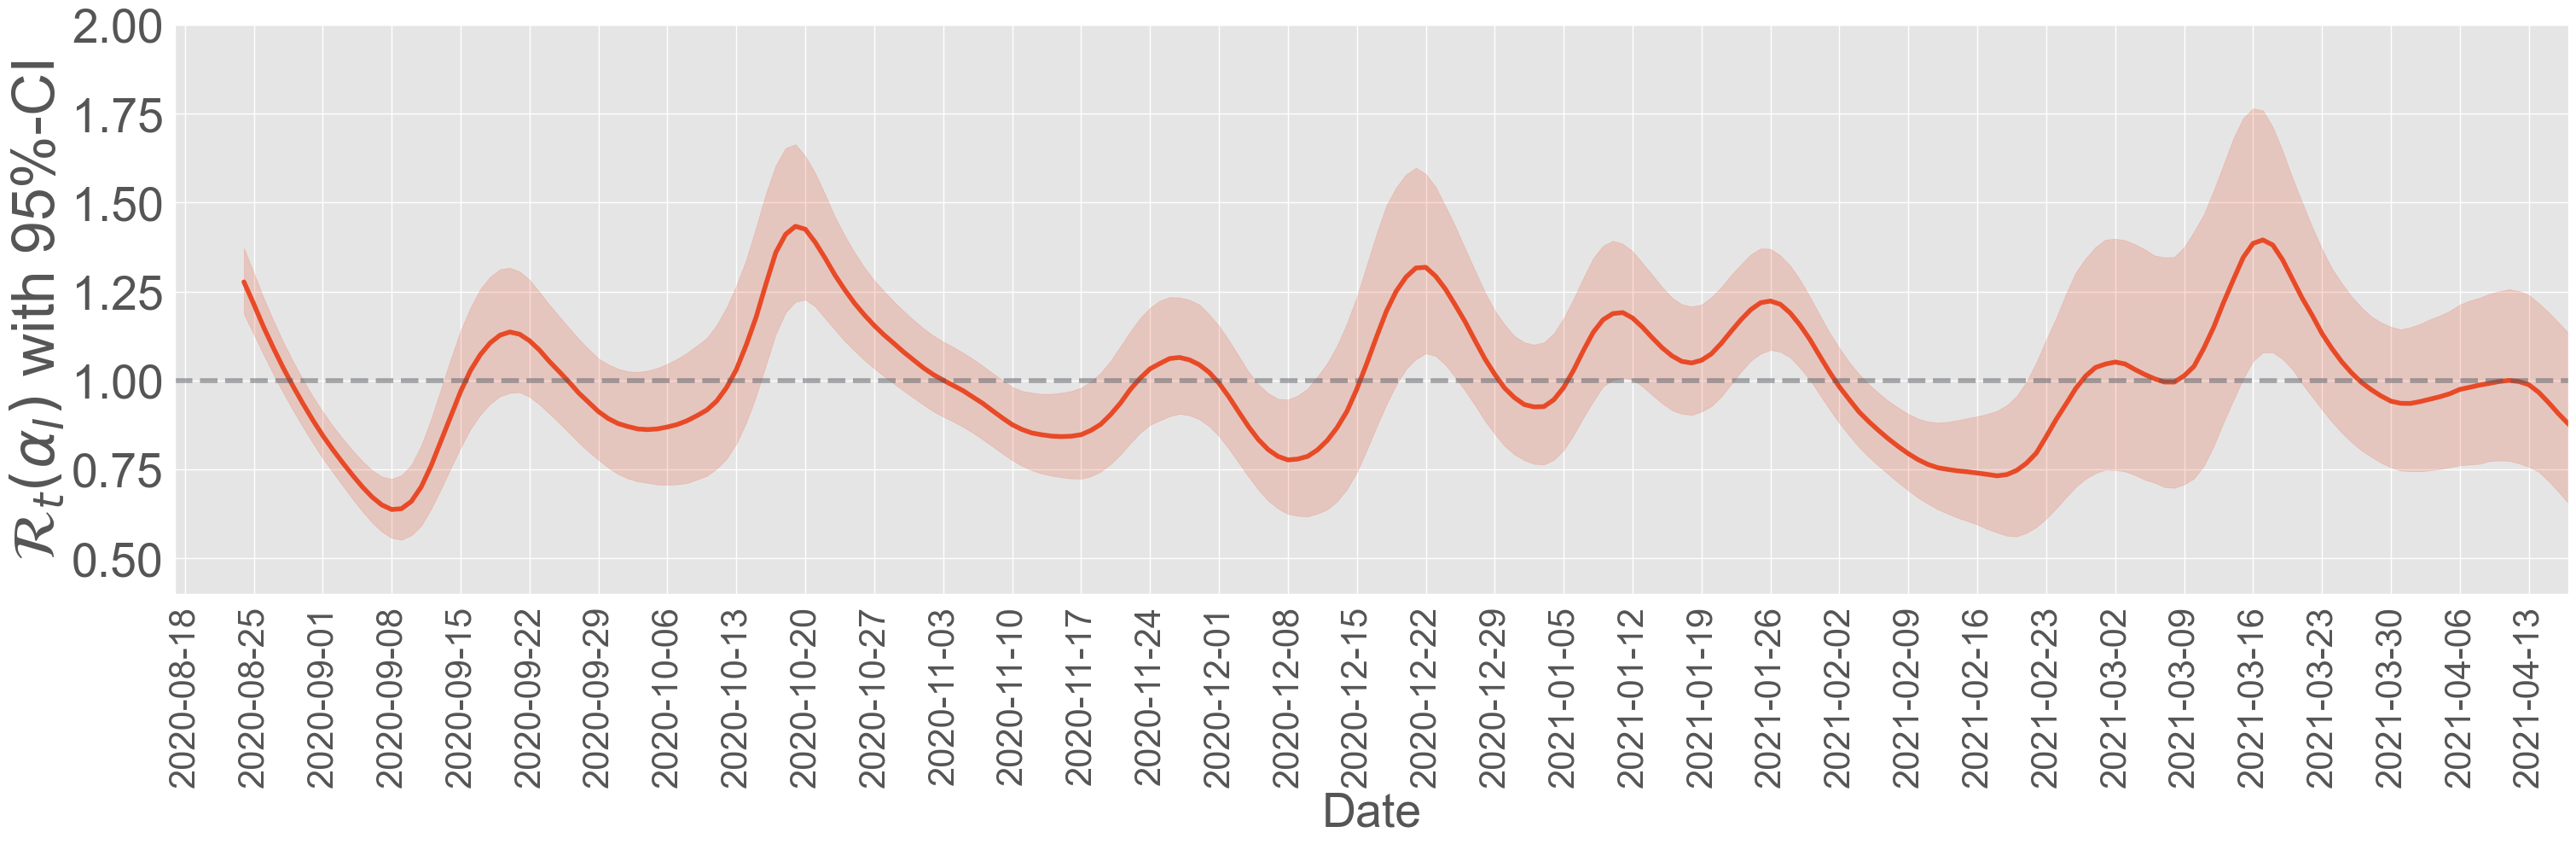

In [117]:
# Ensure the index is in datetime format
UIUC_R.index = pd.to_datetime(UIUC_R.index, errors='coerce')

plt.figure(4)
plt.style.use('ggplot')
fig, ax = plt.subplots(1,1, figsize=(30, 10))

# Plotting the R_mean values
plt.plot(UIUC_R.index, UIUC_R.loc[:,'R_mean'], linewidth=4, color=(232/255, 74/255, 39/255))

# Shaded confidence intervals
ax.fill_between(UIUC_R.index, 
                UIUC_R['Q0.025'], 
                UIUC_R['Q0.975'], 
                color=(232/255, 74/255, 39/255), alpha=0.2)

# Force x-axis to start exactly at 2020-08-18
ax.set_xlim([pd.Timestamp('2020-08-17'), pd.Timestamp('2021-04-17')])

# Use DayLocator to set ticks every 7 days, starting from 2020-08-18
start_date = datetime.datetime(2020, 8, 18)
ax.xaxis.set_major_locator(mdates.DayLocator(interval=7))

# Format x-axis ticks to display dates
ax.xaxis.set_major_locator(mdates.WeekdayLocator())

# Set labels and axis formatting
ax.set_xlabel('Date', fontsize=40)
ax.set_ylabel(r'$\mathcal{R}_t(\alpha_I)$ with 95%-CI', fontsize=50)
ax.set_ylim([0.4, 2])

# Add a horizontal line at y=1
ax.axhline(y=1, color=(85/255, 89/255, 96/255), linewidth=4, linestyle='dashed', alpha=0.5)

# Rotate x-axis labels for better readability
ax.tick_params(axis='x', rotation=90)
plt.xticks(fontsize=30)
plt.yticks(fontsize=40)

# Show the plot
plt.show()

In [118]:
# reconstruct the spreading process in Fall 2020
uiuc_r_fall = UIUC_R.loc['2020-08-17':'2020-12-21','Q0.5']
uiuc_r_fall_upper = UIUC_R.loc['2020-08-17':'2020-12-21','Q0.975']
uiuc_r_fall_lower = UIUC_R.loc['2020-08-17':'2020-12-21','Q0.025']

In [119]:
#initial conditions
uiuc_simulated_fall = sim_inf(
    seed=[40, 50, 80, 40, 86, 82, 143, 148, 164,88], r_ts=uiuc_r_fall, serial_UIUC_New_U = serial_UIUC_New_U)

Text(0.5, 1.0, 'True incidence')

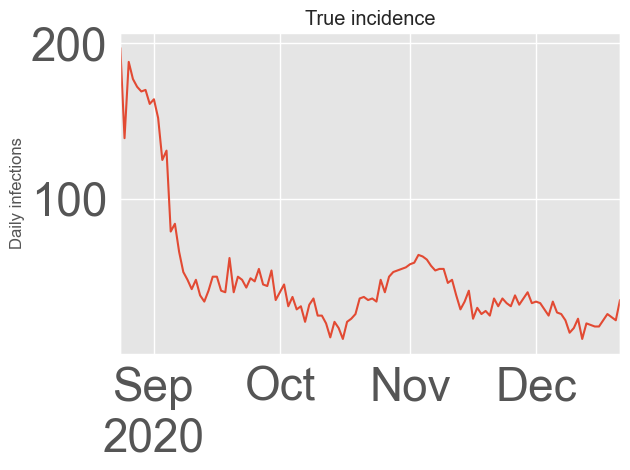

In [120]:
fig, ax = plt.subplots()
uiuc_simulated_fall.plot(ax=ax)
ax.set_ylabel("Daily infections")
ax.set_title("True incidence")

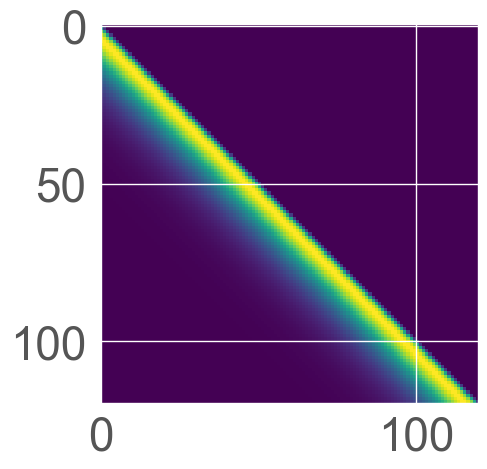

In [121]:
# generate noise and weekly patterns
import scipy.linalg as la
delay_distrb = covid19.generate_standard_infection_to_reporting_distribution()
bs_confirmed_cases = bootstrap.bootstrap_series(UIUC_Total_Confirm)
sm_bs_confirmed_cases = smoothen.smoothen_series(bs_confirmed_cases, 14)
max_likelihood_infections = deconvolution.deconvolve_series(sm_bs_confirmed_cases,delay_distrb)

col = delay_distrb[:120]
row = np.concatenate(([delay_distrb[0]], np.zeros(120 - 1)), axis=None)

delay_kernel = la.toeplitz(col, row)
plt.imshow(delay_kernel[:, :], cmap='viridis')

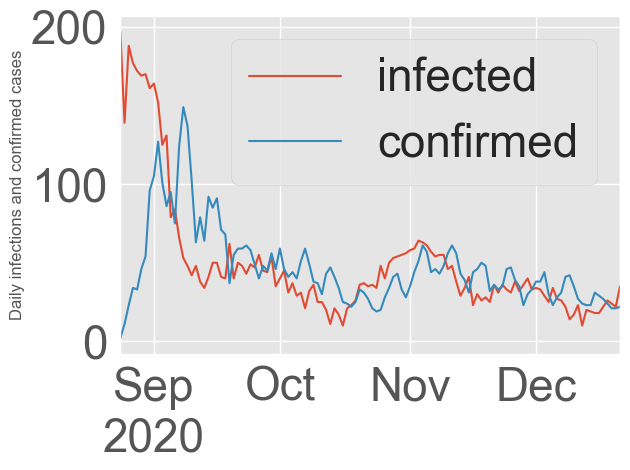

In [122]:
# added delays, noises, and weekly patterns
confirmed_expected = delay_kernel @ uiuc_simulated_fall
confirmed_noise = np.random.normal(0, 1, size=120)/10
week_pattern = np.sin(2*np.pi*np.arange(120)/7)/5
confirmed_cases = pd.Series(confirmed_expected*(1 + confirmed_noise + week_pattern), index=uiuc_simulated_fall.index).astype(int)

fig, ax = plt.subplots()
uiuc_simulated_fall.plot(ax=ax, label='infected')
confirmed_cases.plot(ax=ax, label='confirmed')

ax.set_ylabel("Daily infections and confirmed cases")
ax.legend()

            Confirmed Cases Via Simulation
2020-08-24                               2
2020-08-25                              11
2020-08-26                              23
2020-08-27                              34
2020-08-28                              33
...                                    ...
2020-12-17                              27
2020-12-18                              24
2020-12-19                              21
2020-12-20                              21
2020-12-21                              22

[120 rows x 1 columns]
<class 'pandas.core.frame.DataFrame'>


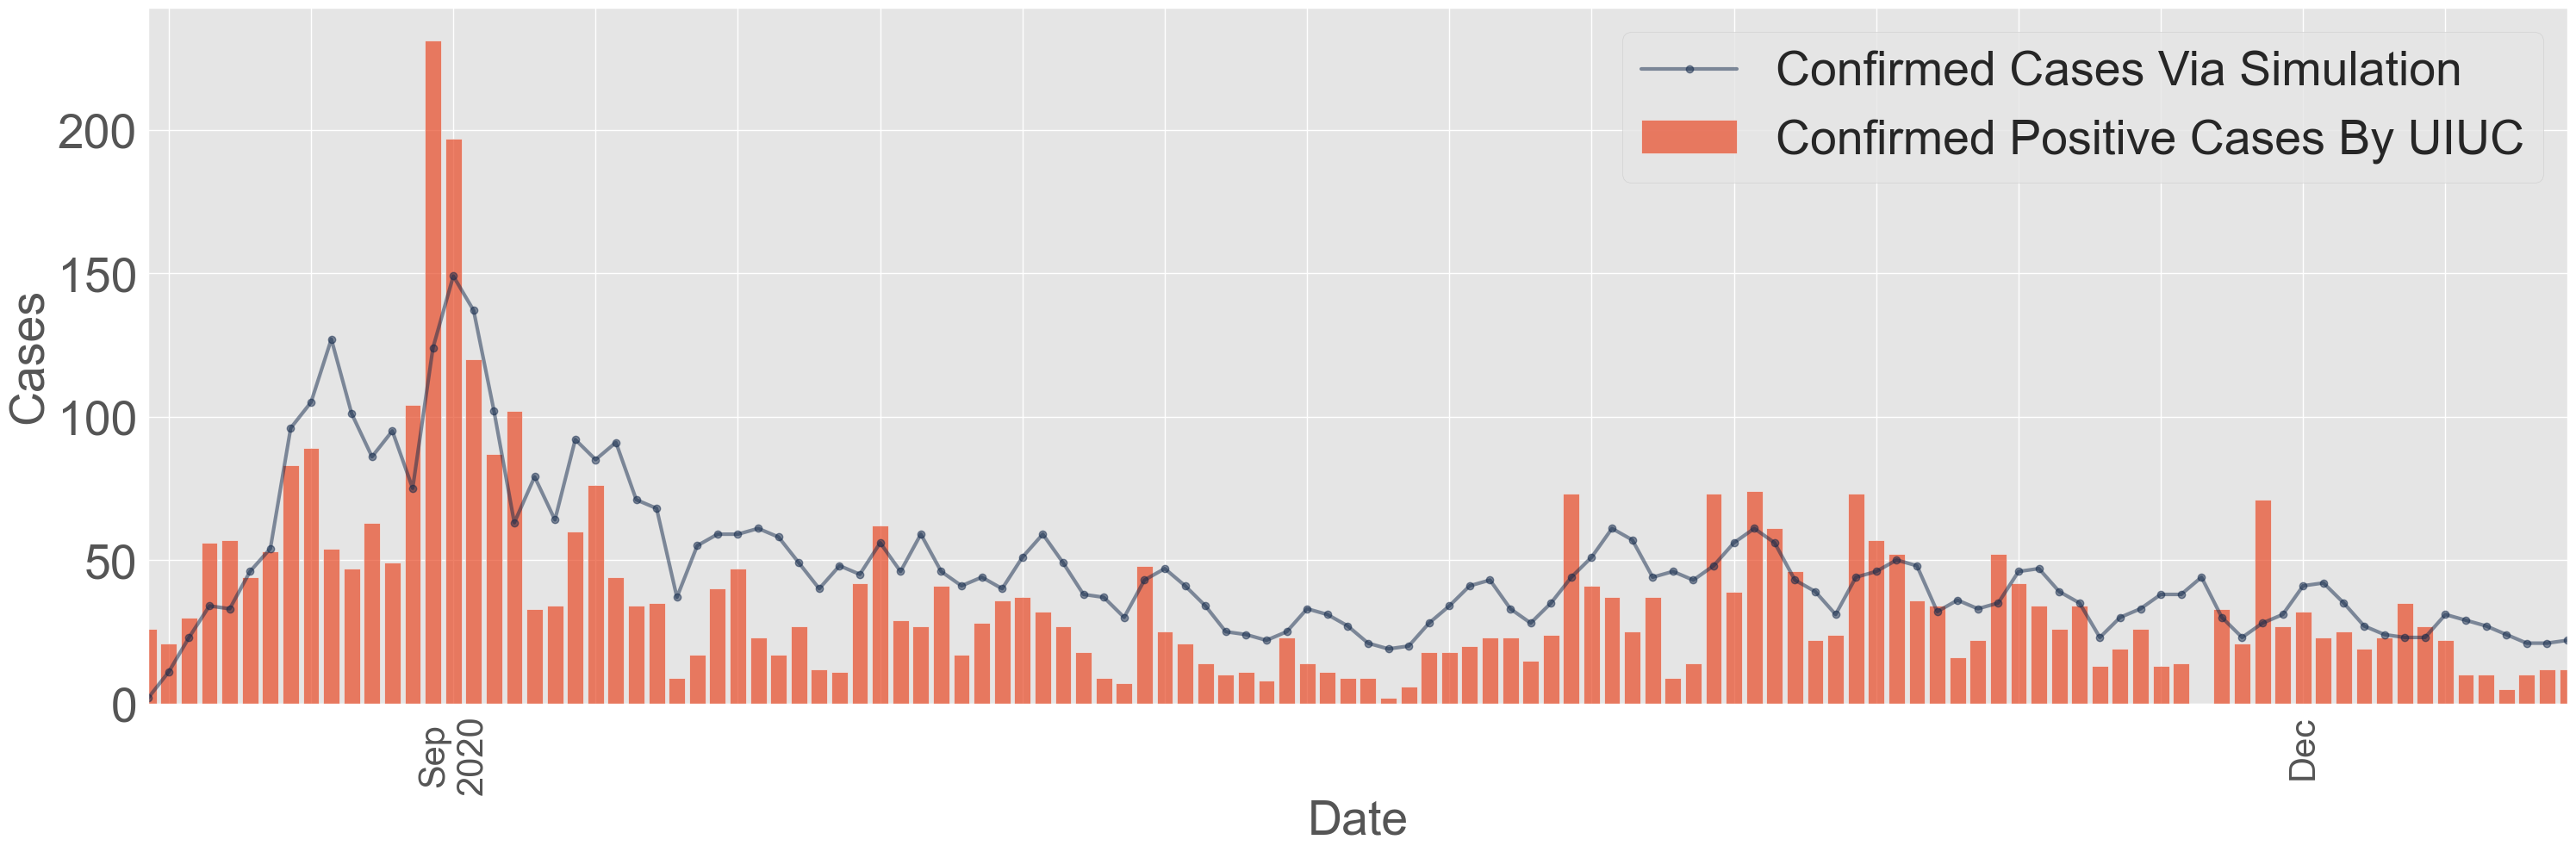

In [123]:
plt.style.use('ggplot')
confirmed_cases.shift(freq='-7D')
df_confirmed_cases=confirmed_cases.to_frame(name='Confirmed Cases Via Simulation')
print(df_confirmed_cases)
print(type(df_confirmed_cases))
df_confirmed_cases_s=df_confirmed_cases.shift(freq='-7D')

#plot data
fig, ax = plt.subplots(figsize=(30,10))
ax.bar(UIUC_Total_Confirm.index, UIUC_Total_Confirm,color=(232/255, 74/255, 39/255, 0.7), label = 'Confirmed Positive Cases By UIUC')
df_confirmed_cases_s.plot(ax=ax, label='Confirmed Cases Via Simulation', color=(19/255, 41/255, 75/255, 0.5),linewidth=3, marker="o")
#set ticks every week
ax.xaxis.set_major_locator(mdates.WeekdayLocator())
ax.legend(fontsize = 40)
#format date

#ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
ax.tick_params(axis='x', rotation=90)
plt.xticks(fontsize = 30)
plt.yticks(fontsize = 40)
#ax.set_title('Confirmed Positive Cases During Fall 2020 at UIUC', fontsize = 30)
ax.set_ylabel('Cases')
ax.set_xlabel('Date')
ax.xaxis.label.set_size(40)
ax.yaxis.label.set_size(40)

In [124]:
# U of Illinois tests everyone three times a week during Spring 2021
Ctrl_in = 3/7;
serial_UIUC_New = serial_UIUC-serial_UIUC
serial_UIUC_New[0]= serial_UIUC[0]
serial_UIUC_New[1]= serial_UIUC[1]

for x in range(2,len(serial_UIUC_New)):
    serial_UIUC_New [x] = (1-Ctrl_in)**(x-1)*serial_UIUC[x]

    
serial_UIUC_New = np.delete(serial_UIUC_New, [0])
serial_UIUC_New_U = serial_UIUC_New / np.sum(serial_UIUC_New)

In [125]:
# Simulate infected cases at UIUC during Spring 2021
uiuc_r_spring = UIUC_R.loc['2020-12-22':'2021-04-27','Q0.5']
uiuc_simulated_spring= sim_inf(
    seed=[3, 8, 6, 2, 5, 11, 4, 12, 10, 4], r_ts=uiuc_r_spring, serial_UIUC_New_U= serial_UIUC_New_U
)

Text(0.5, 1.0, 'True incidence')

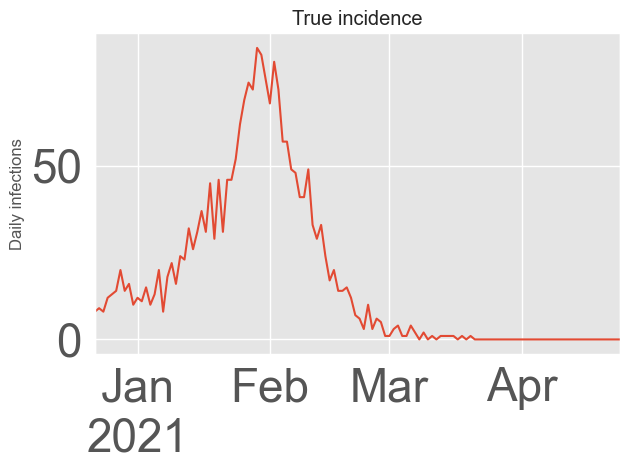

In [126]:
fig, ax = plt.subplots()
uiuc_simulated_spring.plot(ax=ax)
ax.set_ylabel("Daily infections")
ax.set_title("True incidence")

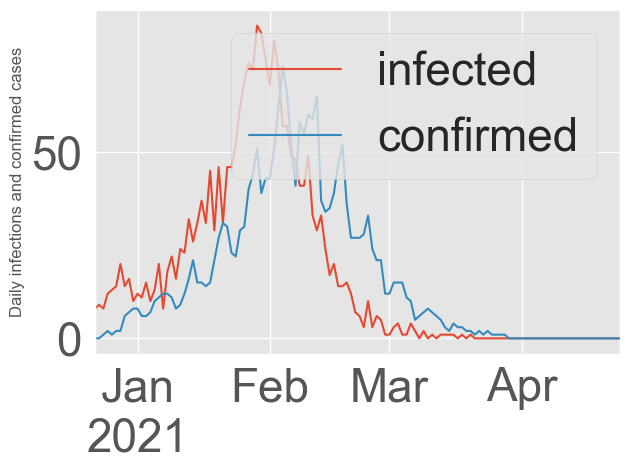

In [127]:
# use the same method to add delays, noise, and weekly pattern
col = delay_distrb[:124]
row = np.concatenate(([delay_distrb[0]], np.zeros(124 - 1)), axis=None)
delay_kernel = la.toeplitz(col, row)


confirmed_expected = delay_kernel @ uiuc_simulated_spring
confirmed_noise = np.random.normal(0, 1, size=124)/10
week_pattern = np.sin(2*np.pi*np.arange(124)/7)/5
confirmed_cases_spring = pd.Series(confirmed_expected*(1 + confirmed_noise + week_pattern), index=uiuc_simulated_spring.index).astype(int)

fig, ax = plt.subplots()
uiuc_simulated_spring.plot(ax=ax, label='infected')
confirmed_cases_spring.plot(ax=ax, label='confirmed')

ax.set_ylabel("Daily infections and confirmed cases")
ax.legend()

            Confirmed Cases Via Simulation
2020-12-22                               0
2020-12-23                               0
2020-12-24                               1
2020-12-25                               2
2020-12-26                               1
...                                    ...
2021-04-20                               0
2021-04-21                               0
2021-04-22                               0
2021-04-23                               0
2021-04-24                               0

[124 rows x 1 columns]
<class 'pandas.core.frame.DataFrame'>


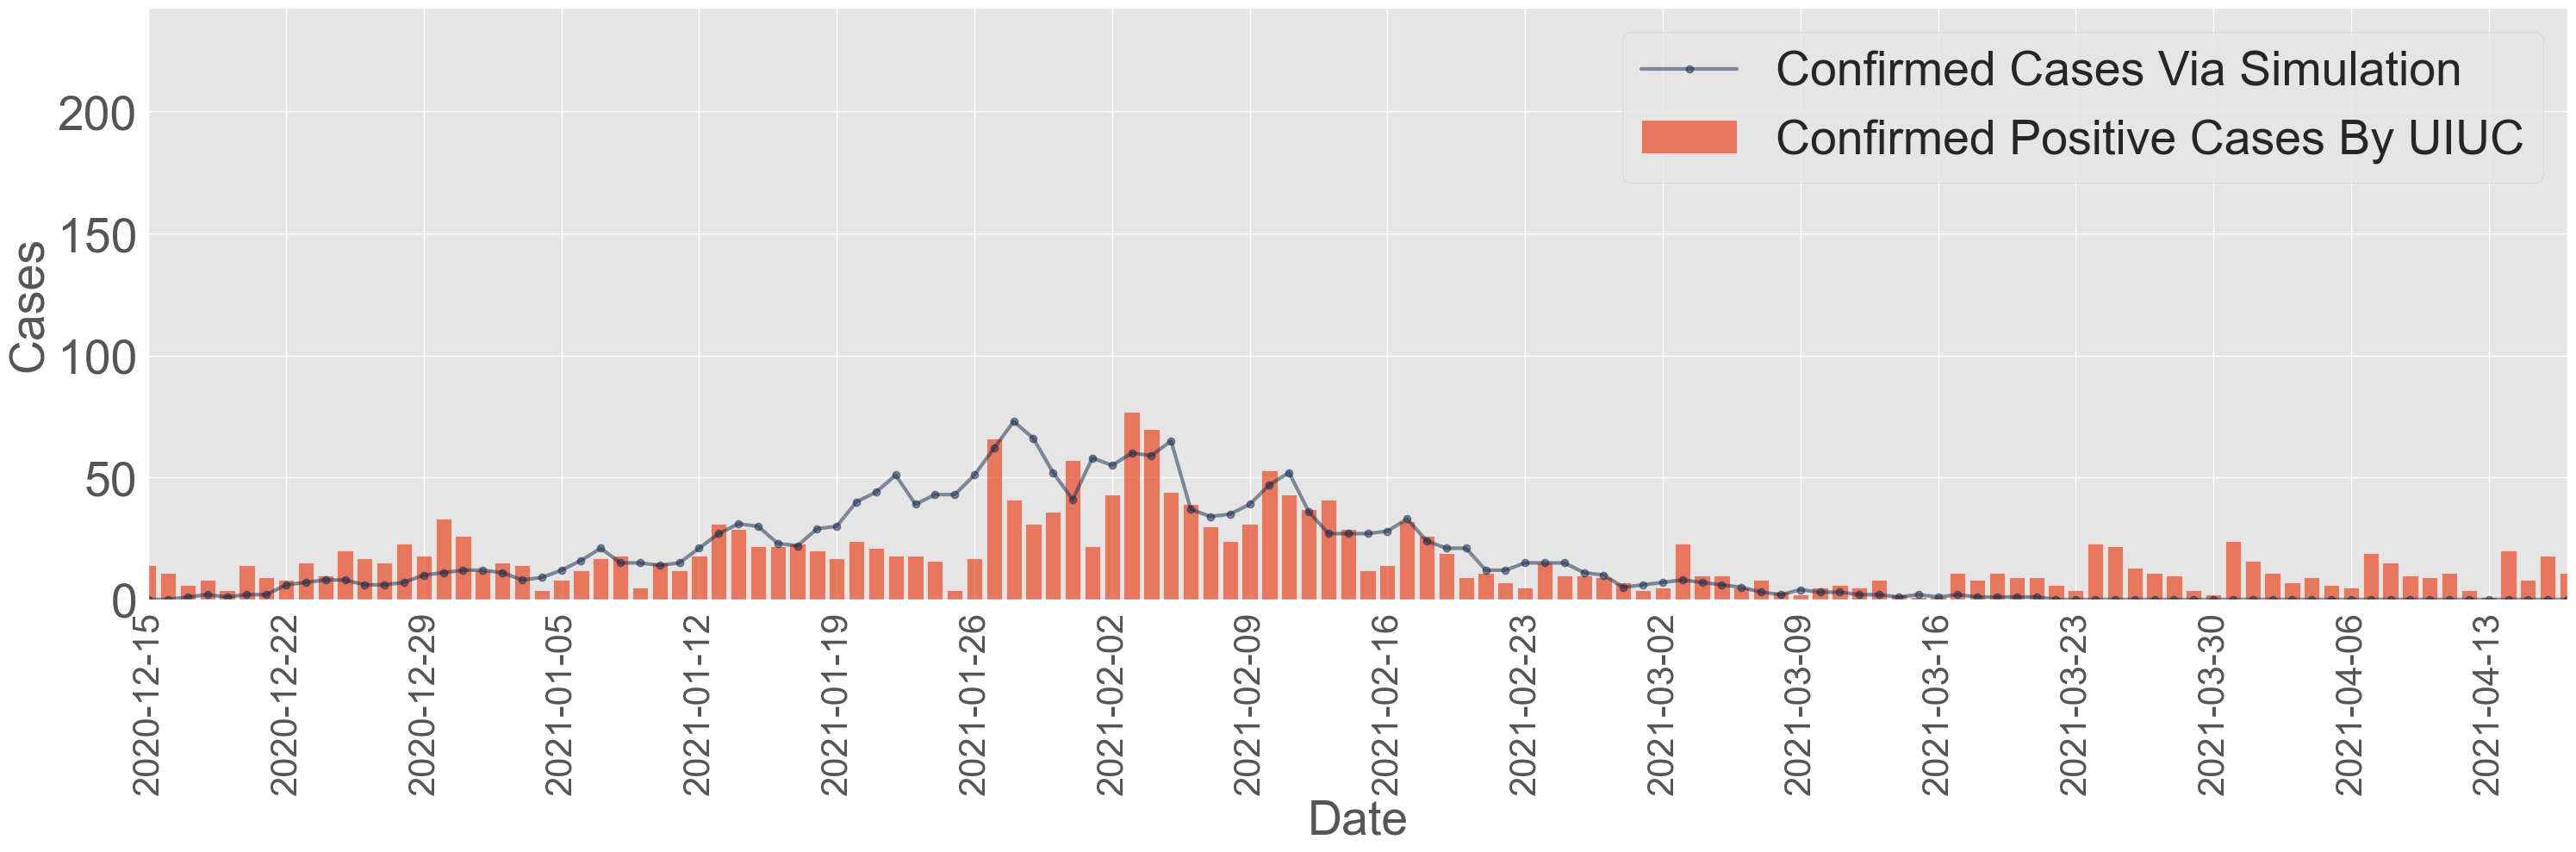

In [128]:
# plot the simulated confirmed cases at UIUC during Spring 2021
confirmed_cases_spring.shift(freq='-7D')
df_confirmed_cases_spring=confirmed_cases_spring.to_frame(name='Confirmed Cases Via Simulation')
print(df_confirmed_cases_spring)
print(type(df_confirmed_cases_spring))
df_confirmed_cases_s_spring=df_confirmed_cases_spring.shift(freq='-7D')

#plot data
fig, ax = plt.subplots(figsize=(30,10))
ax.bar(UIUC_Total_Confirm.index, UIUC_Total_Confirm,color=(232/255, 74/255, 39/255, 0.7), label = 'Confirmed Positive Cases By UIUC')
df_confirmed_cases_s_spring.plot(ax=ax, label='Confirmed Cases Via Simulation', color=(19/255, 41/255, 75/255, 0.5),linewidth=3, marker="o")
#set ticks every week
ax.xaxis.set_major_locator(mdates.WeekdayLocator())
ax.legend(fontsize = 40)
#format date

#ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

ax.tick_params(axis='x', rotation=90)
plt.xticks(fontsize = 30)
plt.yticks(fontsize = 40)
#ax.set_title('Confirmed Positive Cases During Fall 2020 at UIUC', fontsize = 30)
ax.set_ylabel('Cases')
ax.set_xlabel('Date')
ax.xaxis.label.set_size(40)
ax.yaxis.label.set_size(40)

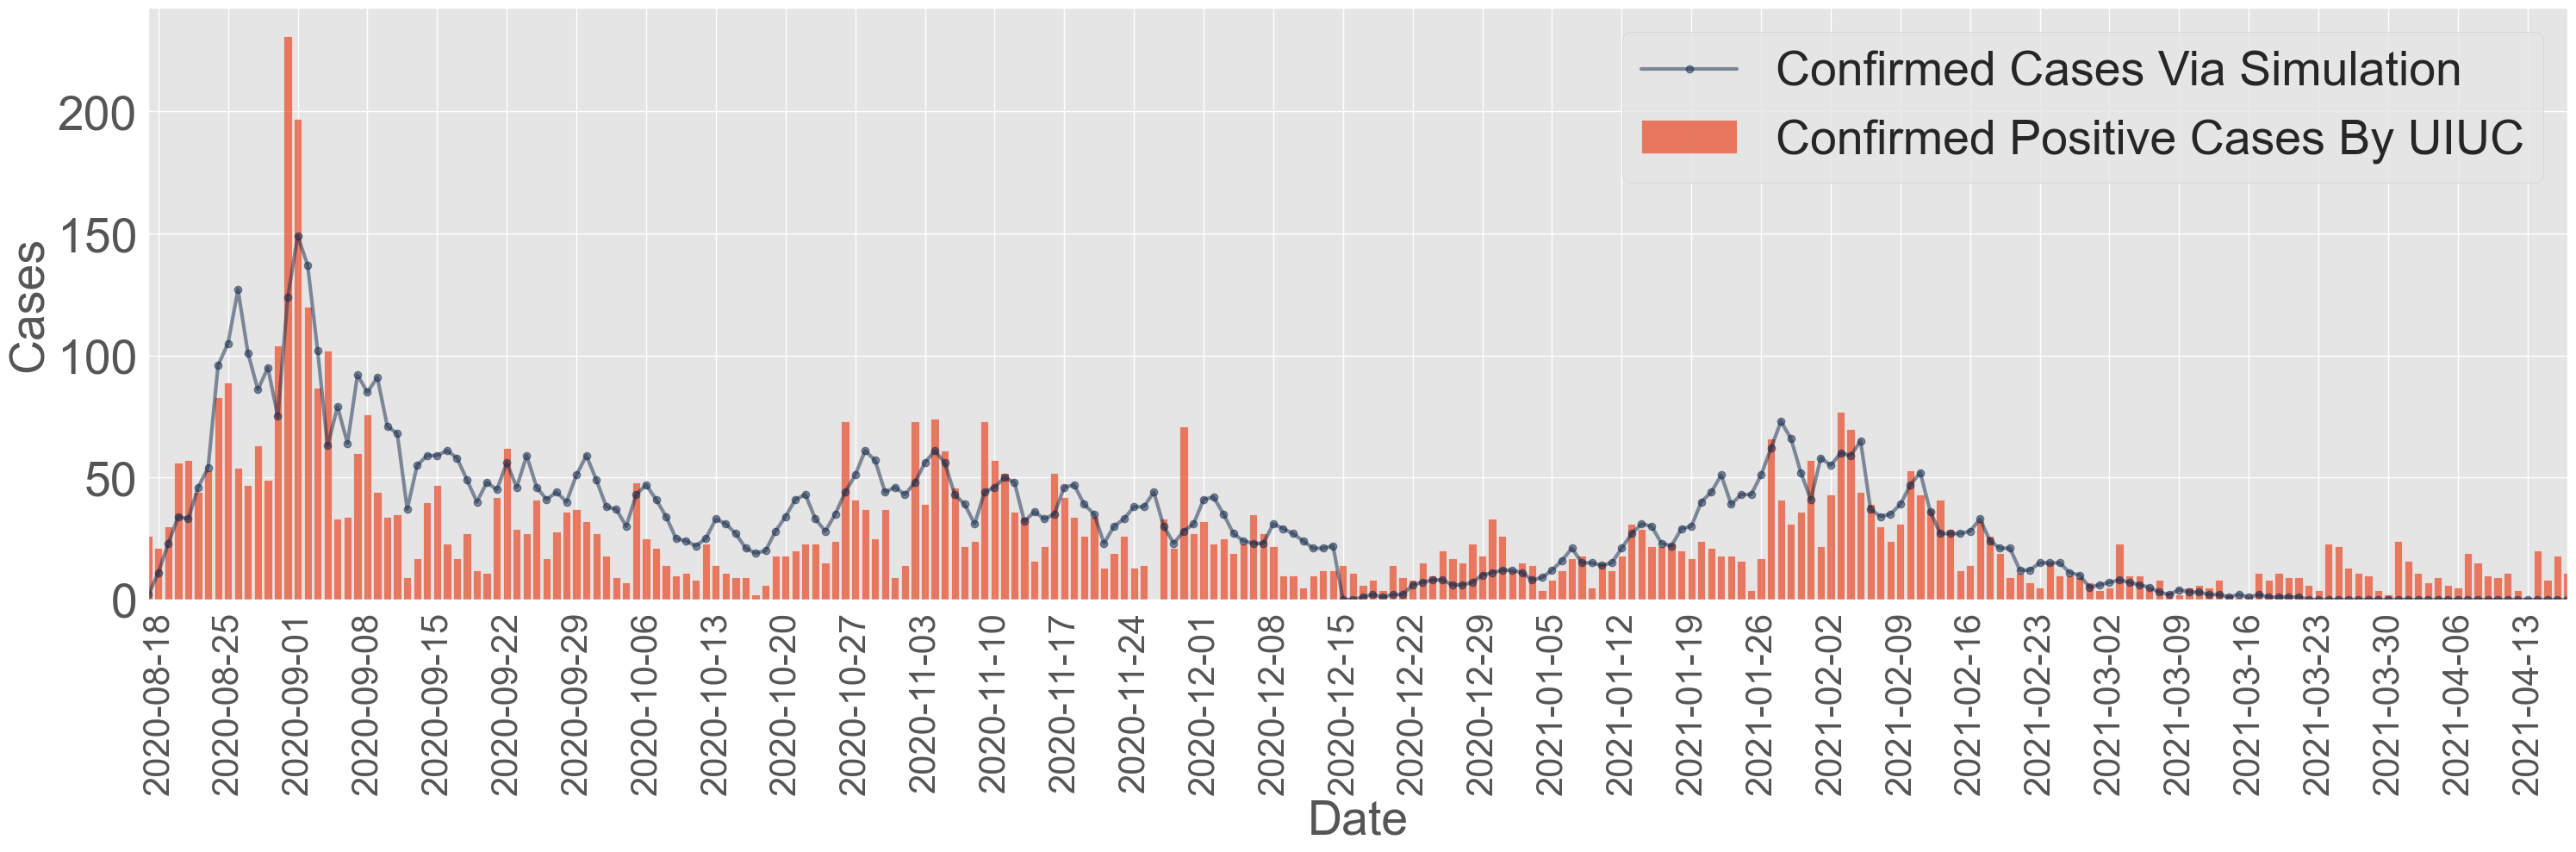

In [129]:
# Put the simulated confirmed cases from Fall 2020 and Spring 2021 in the same plot
df_confirmed_total =  pd.concat([df_confirmed_cases_s, df_confirmed_cases_s_spring])

fig, ax = plt.subplots(figsize=(30,10))
ax.bar(UIUC_Total_Confirm.index, UIUC_Total_Confirm,color=(232/255, 74/255, 39/255, 0.7), label = 'Confirmed Positive Cases By UIUC')
df_confirmed_total.plot(ax=ax, label='Confirmed Cases Via Simulation', color=(19/255, 41/255, 75/255, 0.5),linewidth=3, marker="o")
#set ticks every week
ax.xaxis.set_major_locator(mdates.WeekdayLocator())
ax.legend(fontsize = 40)
#format date

#ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

ax.tick_params(axis='x', rotation=90)
plt.xticks(fontsize = 30)
plt.yticks(fontsize = 40)
#ax.set_title('Confirmed Positive Cases During Fall 2020 at UIUC', fontsize = 30)
ax.set_ylabel('Cases')
ax.set_xlabel('Date')
ax.xaxis.label.set_size(40)
ax.yaxis.label.set_size(40)

In [130]:
# Reconstruction with zero isolation rate

In [131]:
# Reconstruction with zero isolation rate (Fall 2020 only)
# scale the infection profile
base_t = 2 # testing percentage for initial settings (0.55 testing rate or 0.55 symptomatic cases if we don't test)
window_t = 7 # testing window size
base_test = 1-base_t/window_t

serial_UIUC_New = serial_UIUC-serial_UIUC
serial_UIUC_New[0]= serial_UIUC[0]
serial_UIUC_New[1]= serial_UIUC[1]

for x in range(2,len(serial_UIUC_New)):
    serial_UIUC_New [x] = base_test**(x-1)*serial_UIUC[x]

# compute the scaling factor F    
serial_test = serial_UIUC_New/sum(serial_UIUC_New)
Scalor_UIUC = sum(serial_UIUC_New)/sum(serial_UIUC)
Scalor = Scalor_UIUC   #fixed scaling factor

In [132]:
# compute the scaled serial interval distribution
serial_UIUC_O = serial_UIUC/sum(serial_UIUC) 
serial_UIUC_O = np.delete(serial_UIUC_O, [0])
serial_UIUC_U = np.delete(serial_UIUC_New, [0]) #original from UIUC

In [133]:
# Construct the loops

# setting simulation spreading parameters
# Initial Conditions 

N_Data_Len = 120
true_r = uiuc_r_fall                                                 # Assign true reproduction numbers, estimated from UIUC's data
seed_update = [40, 50, 80, 40, 86, 82, 143, 148, 164,88]            # Initial Conditions; Update recursively
seed_update_no = [40, 50, 80, 40, 86, 82, 143, 148, 164,88] 
# Define a function of generating synthetic data



# Run the simulation

# Updating frequency

Frequency=14
Update_Frequency = list(range(0, N_Data_Len+Frequency, Frequency)); #construct time-window

#initialize the simulation for the first round (set up the initial conditions for the loop)

#
incidence_ts = functions._synthetic_infections_U(
    seed=seed_update, r_ts=true_r[0:Frequency], SI_interval= serial_UIUC_New_U
)

# first round simulated data incidence_ts, which captures the spreading under testing frequency;

infection_mid = incidence_ts.tolist() #convert pd.series to list
infection_data = infection_mid        #pass data 
seed_update = infection_data[-len(serial_UIUC_U):]  #update initial conditions


# first round simulated data incidence_ts_no, which captures the spreading under no/or a different testing rate

incidence_ts_no = functions._synthetic_infections_U(
    seed=seed_update_no, r_ts=true_r[0:Frequency], SI_interval= serial_UIUC_O
)

infection_mid_no= incidence_ts_no.tolist() #convert pd.series to list
infection_data_no= infection_mid_no     #pass data 
seed_update_no= infection_data_no[-len(serial_UIUC_O):]  #update initial conditions

total_I_No_T = sum(infection_data_no)
seed_update_no=infection_data_no[-len(serial_UIUC_O):]
total_I_No_T_Update = sum(infection_data_no) # total infected population without/or a different testing strategy after the first round
total_I_now_Update= sum(infection_data)      # total infected population with UIUC testing after the first round
Multiplier=Scalor #later stage, change it when changing control input; now it is a constant
Total_pop = 50000



for i in Update_Frequency[2::]:
    
    # 1. Simulating UIUC spreading Processes with testing strategy
    incidence_ts = functions._synthetic_infections_U(
        #seed=[26, 21, 30, 56, 57,44, 53, 83, 89, 54, 47, 63, 49, 104, 231, 197,120, 87], r_ts=true_r
        # seed=[26, 21, 30, 56, 57,44, 53, 83, 231, 197,120] (important, to generate the same infection trend as UIUC)
        seed=seed_update, r_ts=true_r[i+1-Frequency:i], SI_interval= serial_UIUC_New_U
    ) 
    infection_mid = incidence_ts.tolist() #convert pd.series to list
    infection_data.extend(infection_mid)
    seed_update = infection_mid[-len(serial_UIUC_U):]
    
    # 2. Simulating UIUC spreading Processes without testing strategy
    
   
    infection_data_pass=infection_data
    total_I_now = sum(infection_data_pass)
    
    incidence_ts_no= functions._synthetic_infections_Rt(
        seed=seed_update_no, r_ts=true_r[i+1-Frequency:i],serial_UIUC_U= serial_UIUC_O,total_I_No_T=total_I_No_T_Update,total_I_now=sum(infection_data_pass),Total_pop=50000, Multiplier=Scalor_UIUC
    ) 
    infection_mid_no = incidence_ts_no.tolist() #convert pd.series to list
    infection_data_no.extend(infection_mid_no)
    seed_update_no= infection_mid_no[-len(serial_UIUC_O):]
    
    total_I_No_T_Update = sum(infection_data_no)
    
    #============================================add delay for data with testing===========================================================

    # output synthetic data: infection_data

    df_infection_data = pd.DataFrame (infection_data, columns = [''])    #convert list into dataframe
    df_infection_data = df_infection_data.squeeze() #convert  dataframe into data.series

    # from infected cases to confirmed cases

    col = delay_distrb[:len(df_infection_data)]
    row = np.concatenate(([delay_distrb[0]], np.zeros(len(df_infection_data)-1)), axis=None)
    delay_kernel = la.toeplitz(col, row)
        


    #compute confirmed cases

    confirmed_expected = delay_kernel @ df_infection_data
    confirmed_noise = np.random.normal(0, 1, size=len(df_infection_data))/10
    week_pattern = np.sin(2*np.pi*np.arange(len(df_infection_data))/7)/5
    
    confirmed_cases = pd.Series(confirmed_expected*(1 + confirmed_noise + week_pattern), index=df_infection_data.index).astype(int)
    
    #============================================add delay for data without testing===========================================================
     # output synthetic data: infection_data

    df_infection_data_no = pd.DataFrame (infection_data_no, columns = [''])    #convert list into dataframe
    df_infection_data_no= df_infection_data_no.squeeze() #convert  dataframe into data.series

    # from infected cases to confirmed cases

    col = delay_distrb[:len(df_infection_data)]
    row = np.concatenate(([delay_distrb[0]], np.zeros(len(df_infection_data)-1)), axis=None)
    delay_kernel = la.toeplitz(col, row)
    #compute confirmed cases

    confirmed_expected_no = delay_kernel @ df_infection_data_no
    confirmed_noise_no= np.random.normal(0, 1, size=len(df_infection_data_no))/10
    week_pattern_no= np.sin(2*np.pi*np.arange(len(df_infection_data_no))/7)/5
    
    confirmed_cases_no= pd.Series(confirmed_expected_no*(1 + confirmed_noise_no + week_pattern_no), index=df_infection_data_no.index).astype(int)

In [134]:
confirmed_cases.name = "Cases"
Confirmed_cases_df = confirmed_cases.to_frame()
Confirmed_cases_df['Date'] = pd.date_range(start='08/24/2020', periods=len(Confirmed_cases_df), freq='D')

confirmed_cases_no.name = "Cases"
Confirmed_cases_df_no = confirmed_cases_no.to_frame()
Confirmed_cases_df_no['Date'] = pd.date_range(start='08/24/2020', periods=len(Confirmed_cases_df_no), freq='D')

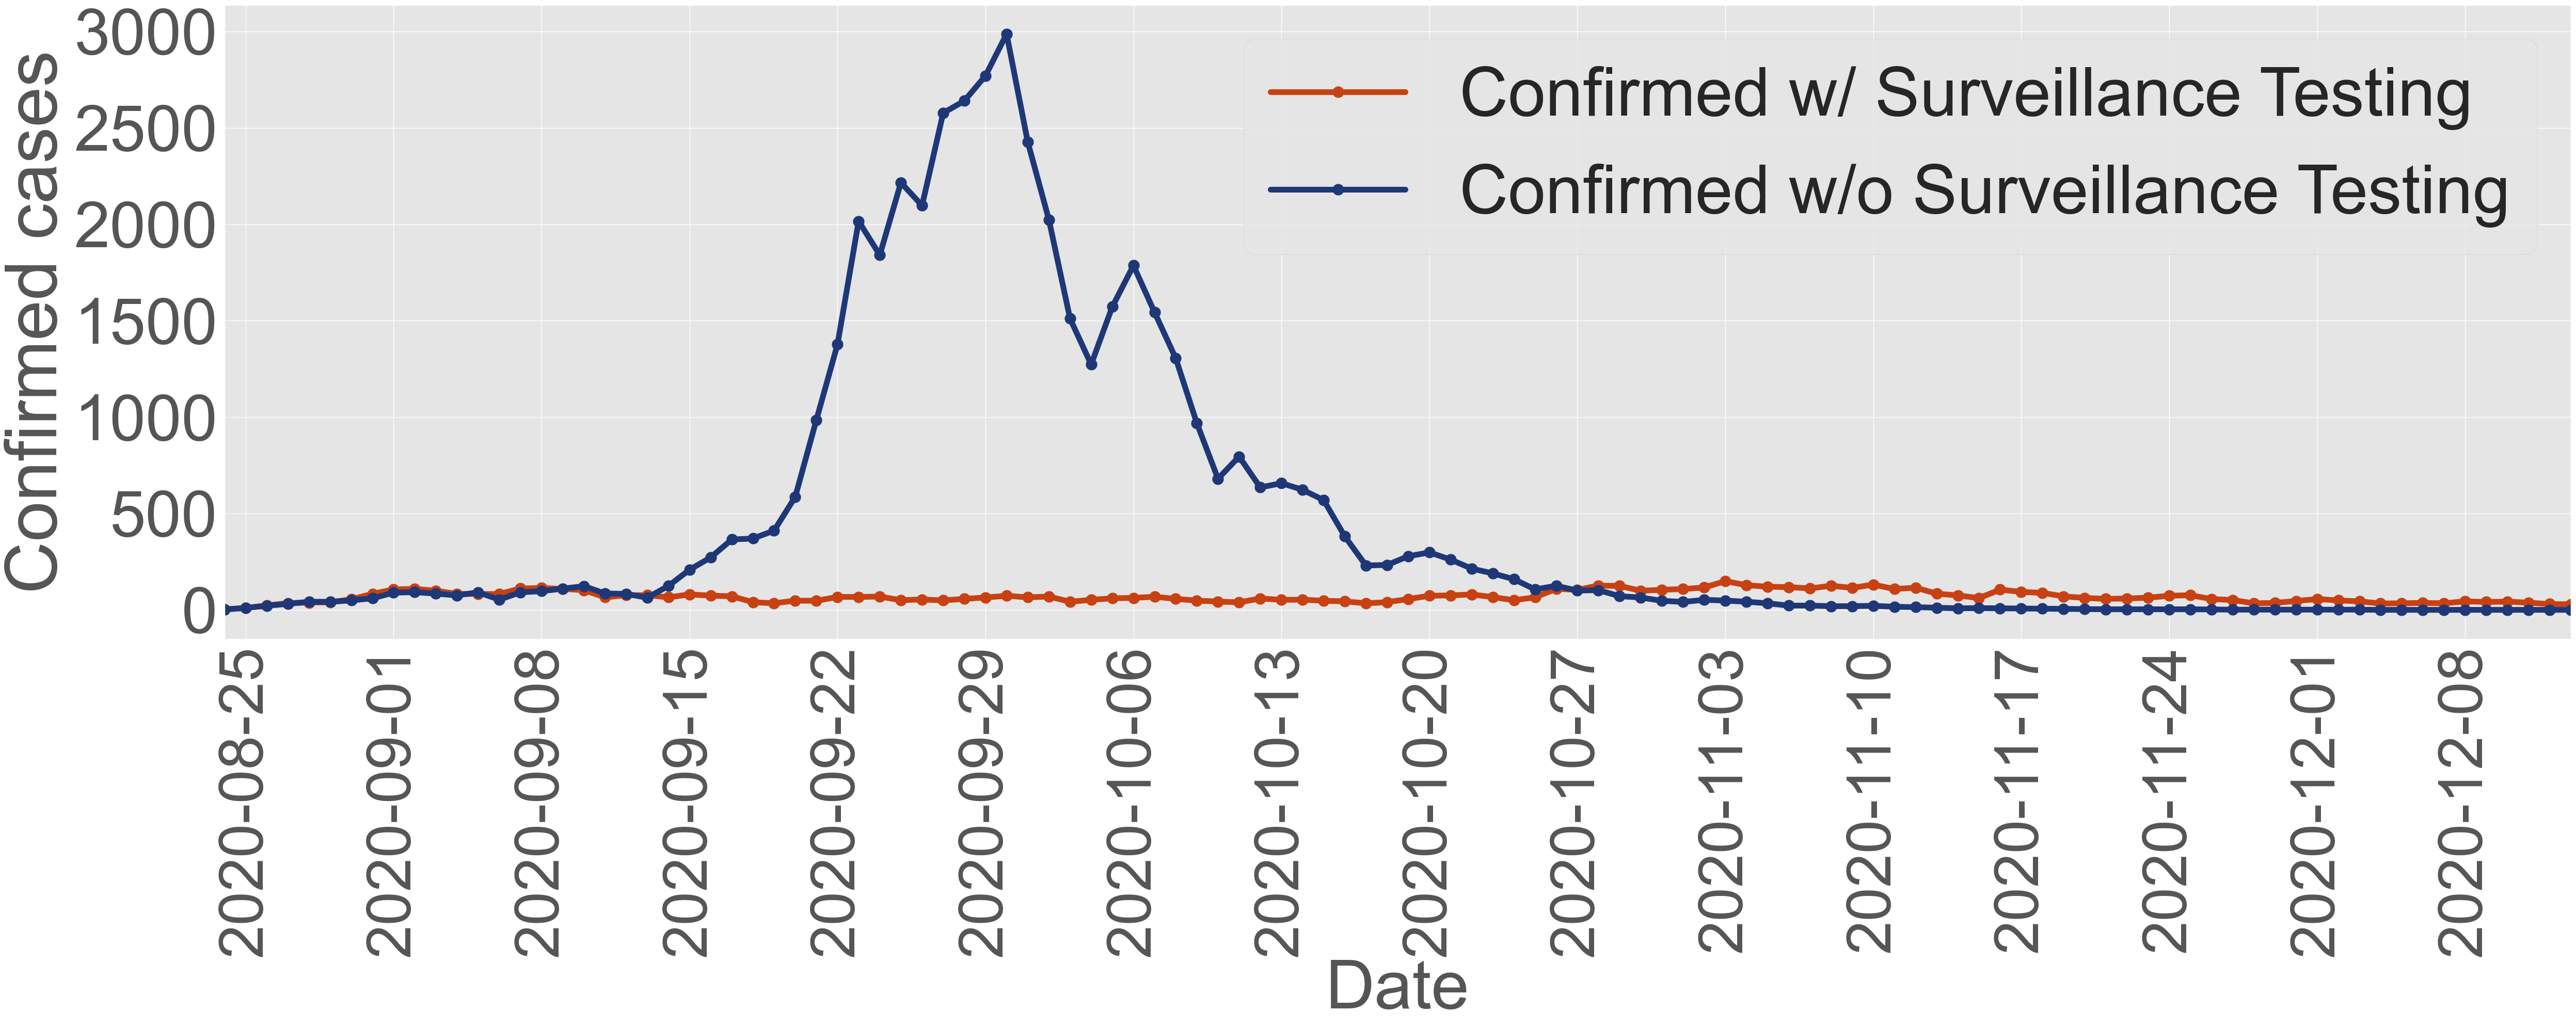

In [135]:
plt.style.use('ggplot')
fig, ax1 = plt.subplots(figsize=(50,20))
Confirmed_cases_df.plot(ax=ax1,x='Date', y ='Cases',fontsize = 660, label='Confirmed w/ Surveillance Testing',linewidth=8,color = "#C84113", marker="o",markersize = 15)
#Fig_1 = Confirmed_cases_df.plot()
Confirmed_cases_df_no_1=Confirmed_cases_df_no
Confirmed_cases_df_no.plot(ax=ax1,x='Date', y ='Cases', label='Confirmed w/o Surveillance Testing',linewidth=8,color= '#1E3877', marker="o", markersize = 15)
#Confirmed_cases_df_no_1.plot(ax=ax1,x='Date', label='infected',linewidth=2, marker="o")
ax1.tick_params(axis='x', rotation=90)
plt.xticks(fontsize = 85)
plt.yticks(fontsize = 90)
# ax.xaxis.set_major_locator(mdates.WeekdayLocator())
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax1.xaxis.set_major_locator(mdates.WeekdayLocator())

  
                        
ax1.set_ylabel("Confirmed cases", fontsize = 90)
#ax1.set_title('Confirmed Positive Cases During Fall 2020', fontsize = 25)
ax1.xaxis.label.set_size(95)
ax1.yaxis.label.set_size(101)
ax1.legend(fontsize=94)
#plt.gcf().set_size_inches(40, 20)

In [136]:
true_r_list = true_r.values.tolist()
R_wo_test = functions._Rt_update(R_Test = true_r_list, Daily_infection_1 = infection_data_no, Daily_infection_2 = infection_data, Scaling_factor = Scalor, Population = Total_pop)
R_wo_test_pd = pd.DataFrame (R_wo_test, columns = [''])
R_direct =true_r/Scalor

In [137]:
#add on 09/27/2024
true_r_list_uppper = uiuc_r_fall_upper
true_r_list_uppper = true_r_list_uppper.values.tolist()
R_wo_test_uppper = functions._Rt_update(R_Test = true_r_list_uppper, Daily_infection_1 = infection_data_no, Daily_infection_2 = infection_data, Scaling_factor = Scalor, Population = Total_pop)
R_wo_test_pd_upper= pd.DataFrame (R_wo_test_uppper, columns = [''])

true_r_list_lower = uiuc_r_fall_lower
true_r_list_lower = true_r_list_lower.values.tolist()
R_wo_test_lower = functions._Rt_update(R_Test = true_r_list_lower, Daily_infection_1 = infection_data_no, Daily_infection_2 = infection_data, Scaling_factor = Scalor, Population = Total_pop)
R_wo_test_pd_lower= pd.DataFrame (R_wo_test_lower, columns = [''])

In [138]:
# add on 2024-09-27
true_r_upper = uiuc_r_fall_upper
true_r_df_upper = true_r_upper.to_frame()
true_r_df_upper.columns =['Estimated Reproduction Number at UIUC']

# add on 2024-09-27
true_r_lower = uiuc_r_fall_lower
true_r_df_lower = true_r_lower.to_frame()
true_r_df_lower.columns =['Estimated Reproduction Number at UIUC']

In [139]:
true_r.name = "r_uiuc"
true_r_df = true_r.to_frame()
true_r_df.columns =[r'Effective Reproduction Number $\mathcal{R}_t(\alpha_I)$ at UIUC']


# add on 2024-09-27 
true_r_df_upper = true_r_upper.to_frame()
true_r_df_upper.columns =['Estimated Reproduction Number at UIUC']

true_r_df_lower = true_r_lower.to_frame()
true_r_df_lower.columns =['Estimated Reproduction Number at UIUC']




R_wo_test_pd.name = "Cases"
R_wo_test_pd['Date'] = pd.date_range(start='08/24/2020', periods=len(R_wo_test_pd), freq='D')


#added 09-27-2024
R_wo_test_pd_upper.name = "Cases"
R_wo_test_pd_upper['Date'] = pd.date_range(start='08/24/2020', periods=len(R_wo_test_pd_upper), freq='D')

R_wo_test_pd_lower.name = "Cases"
R_wo_test_pd_lower['Date'] = pd.date_range(start='08/24/2020', periods=len(R_wo_test_pd_upper), freq='D')

In [140]:
R_df = true_r_df
R_df_no= R_wo_test_pd.rename(columns = {"" : "Rt_no"})

#added 09-27-2024
R_df_upper= true_r_df_upper
R_df_lower = true_r_df_lower
R_df_no_upper = R_wo_test_pd_upper.rename(columns = {"" : "Rt_no_upper"})
R_df_no_lower = R_wo_test_pd_lower.rename(columns = {"" : "Rt_no_lower"})

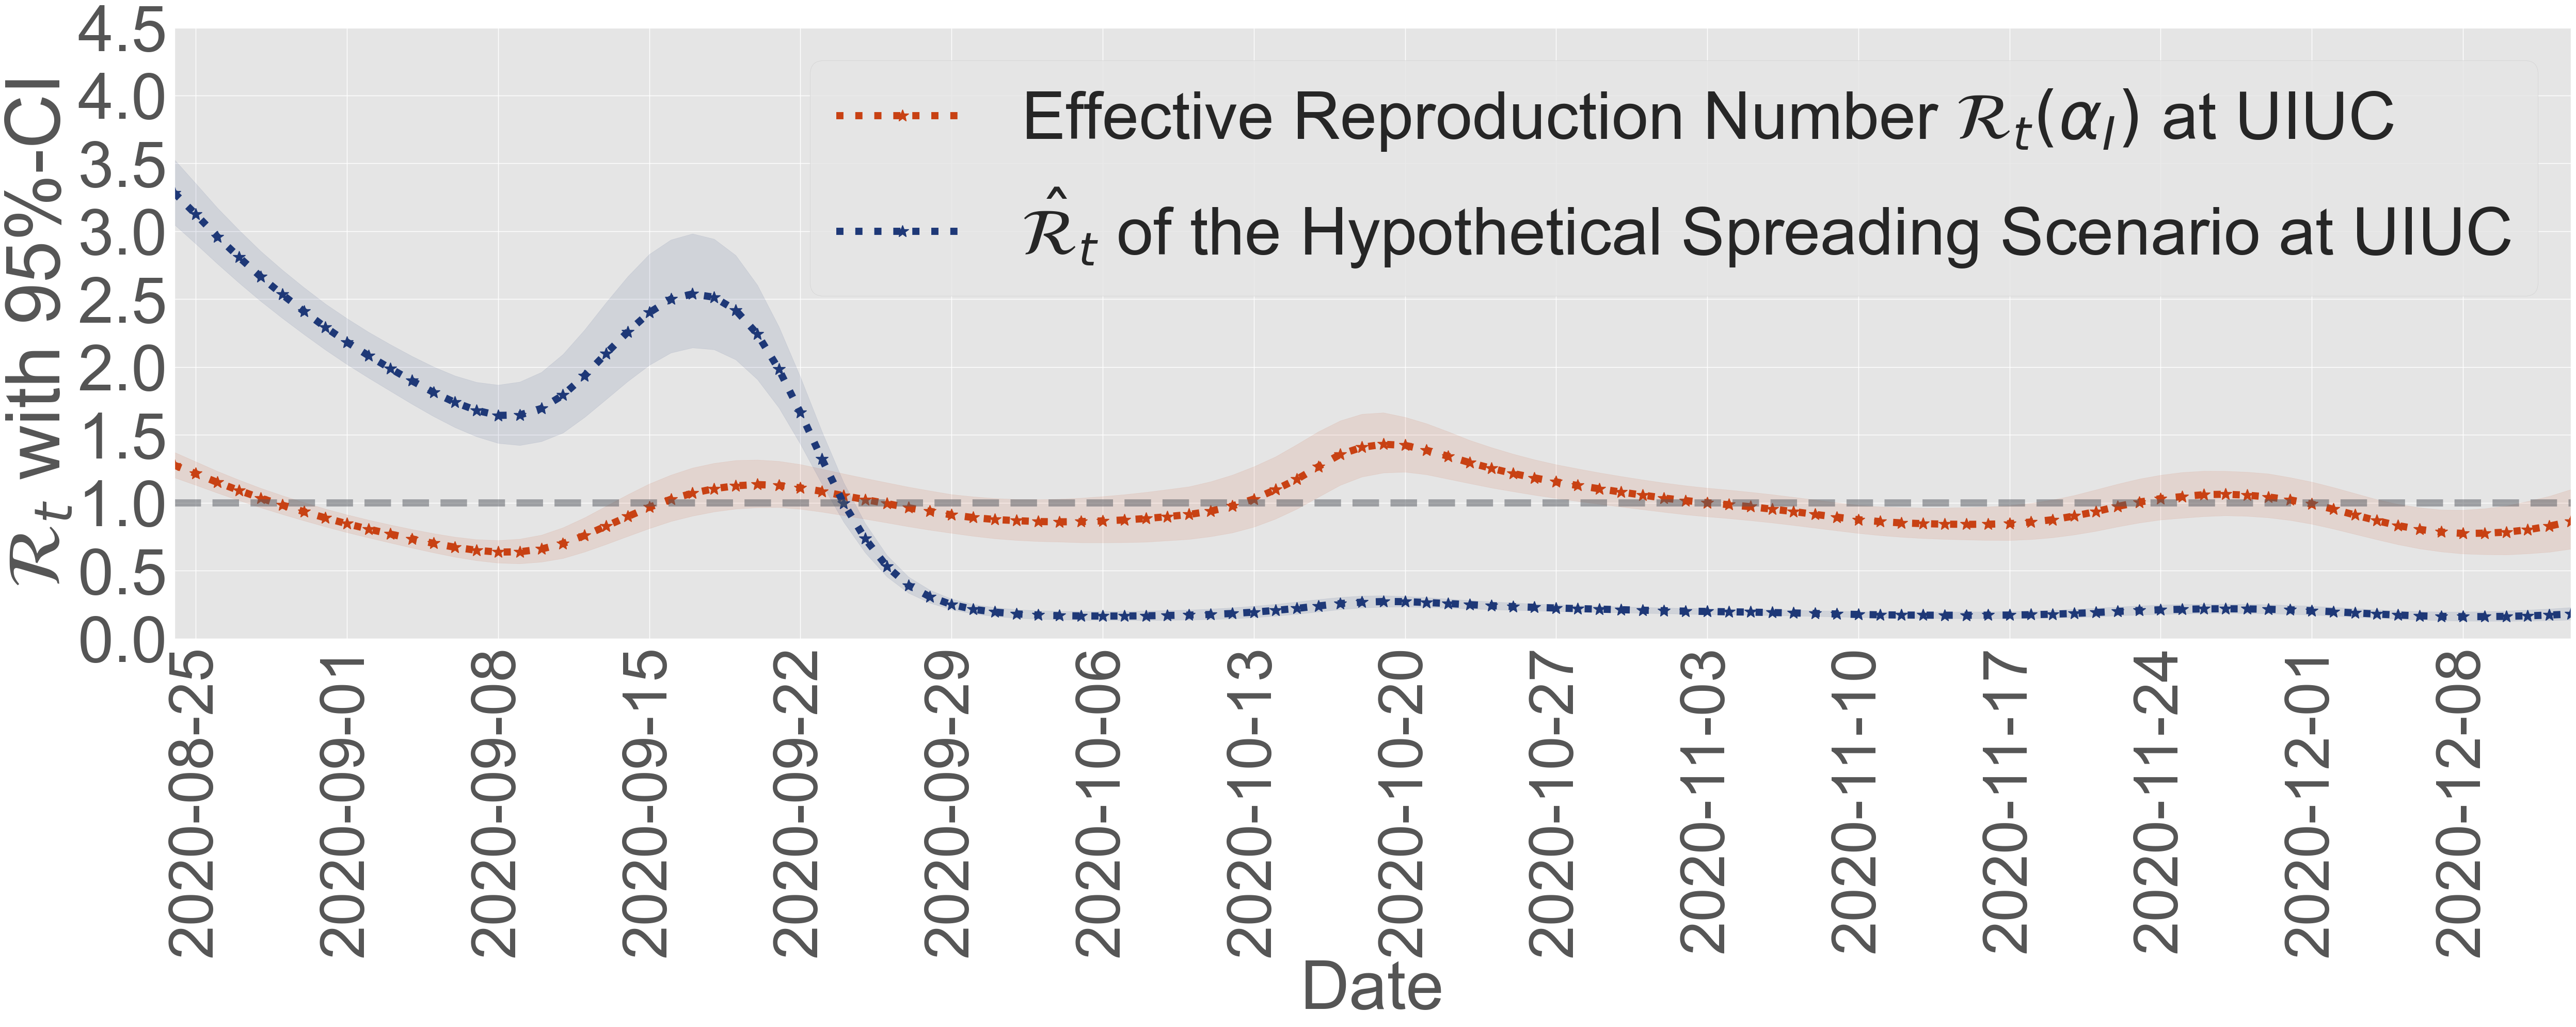

In [141]:
plt.style.use('ggplot')
#compare the change of the reproduction numbers
fig, ax2 = plt.subplots(figsize=(50,20))
R_df.plot(ax=ax2, linestyle='dotted', label =r'Effective Reproduction Number $\mathcal{R}_t(\alpha_I)$ at UIUC', linewidth=10, marker="*", markersize = 18, color = "#C84113")
R_df_no.plot(ax=ax2,x='Date', y = 'Rt_no', linestyle='dotted', label= r'$\hat{\mathcal{R}}_t$ of the Hypothetical Spreading Scenario at UIUC',color = "#1E3877",linewidth=10, marker="*",markersize=18)


# #add 2022-09-27
# R_df_upper.plot(ax=ax2, label='infected_w/o', linestyle='dotted', linewidth=8, marker="*", markersize = 15, color = "#C84113")
# R_df_lower.plot(ax=ax2, label='infected_w/o', linestyle='dotted', linewidth=8, marker="*", markersize = 15, color = "#C84113")

# #add 2022-09-27
# R_df_no_upper.plot(ax=ax2,x='Date', y = 'Rt_no_upper', linestyle='dotted', label= 'Reconstructed Reproduction Number',color = "#1E3877",linewidth=8, marker="*",markersize=15)
# R_df_no_lower.plot(ax=ax2,x='Date', y = 'Rt_no_lower', linestyle='dotted', label= 'Reconstructed Reproduction Number',color = "#1E3877",linewidth=8, marker="*",markersize=15)


ax2.fill_between(R_df.index,
                    R_df_upper['Estimated Reproduction Number at UIUC'],
                    R_df_lower['Estimated Reproduction Number at UIUC'],
                    #color=(255/255, 235/255, 140/255), alpha=0.3)
                    color = "#C84113", alpha=0.1)

ax2.fill_between(R_df.index[0:112],
                    R_df_no_upper['Rt_no_upper'],
                    R_df_no_lower['Rt_no_lower'],
                    #color=(255/255, 235/255, 140/255), alpha=0.3)
                    color = "#1E3877", alpha=0.1)
# Force x-axis to start exactly at 2020-08-18
ax2.set_xlim([pd.Timestamp('2020-08-24'), pd.Timestamp('2020-12-13')])



#R_direct.plot(ax=ax, label='Reconstructed Rt W/O Testing (55% Symptomatic Cases)')
ax2.legend(fontsize = 92)
ax2.tick_params(axis='x', rotation=90)
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax2.xaxis.set_major_locator(mdates.WeekdayLocator())
ax2.axhline(y=1, color=(85/255, 89/255, 96/255), linewidth=10, linestyle='dashed', alpha=0.5)
ax2.set_ylabel("$\mathcal{R}_t$ with 95%-CI",fontsize = 80)
ax2.set_xlabel("Date",fontsize =65)
ax2.set_ylim([0, 4.5])
#ax2.set_title('Effective Reproduction Numbers', fontsize = 25)
plt.xticks(fontsize = 85)
plt.yticks(fontsize = 90)
ax2.xaxis.label.set_size(95)
ax2.yaxis.label.set_size(105)
#plt.gcf().set_size_inches(40, 20)
plt.show()

In [142]:
# Reconstruction with different implemented isolation rate 
# Initialization
df_infection_data_no_total = pd.DataFrame()
confirmed_cases_no_total = pd.DataFrame()

Scalor_New = sum(serial_UIUC_New)/sum(serial_UIUC)
Scalor_Rel= Scalor/Scalor_New

In [143]:
#Weekly isolation rates
Testing_Range = [0, 0.1, 0.2,0.3, 0.4,0.5,0.6, 0.7, 0.8, 0.9, 1.0, 1.2,1.4,1.6, 1.8, 2.0]

In [144]:
for k in Testing_Range:
        # change the testing rate from 1/7 to 0.5/7; 0.3/7; 0.1/7; 0.05/7; Then we can do adaptive testing
        # Constructing infection profile under_baseline testing rate
        serial_UIUC_New = functions._infection_update(testing_rate = 1-k/7, serial_interval = serial_UIUC)
        serial_test = serial_UIUC_New/sum(serial_UIUC_New)
        Scalor_New = sum(serial_UIUC_New)/sum(serial_UIUC)
        
        print (Scalor_New)
        
        # change infection profile to serial interval
        serial_UIUC_U=serial_UIUC_New / sum(serial_UIUC_New)
        #delete the first day
        serial_UIUC_U = np.delete(serial_UIUC_U, [0])
        #Important 
        Scalor_Rel= Scalor/Scalor_New

        N_Data_Len = 120
        true_r = uiuc_r_fall                               # Assign true reproduction numbers, estimated from UIUC's data
        seed_update = [40, 50, 80, 40, 86, 82, 143, 148, 164,88]            # Initial Conditions; Update recursively
        seed_update_no = [40, 50, 80, 40, 86, 82, 143, 148, 164,88] 
        # Define a function of generating synthetic data



        # Updating frequency

        Frequency=14
        Update_Frequency = list(range(0, N_Data_Len+Frequency, Frequency)); #construct time-window

        #initiate the simulation from the first round 
        incidence_ts = functions._synthetic_infections_U(
                #seed=[26, 21, 30, 56, 57,44, 53, 83, 89, 54, 47, 63, 49, 104, 231, 197,120, 87], r_ts=true_r
                # seed=[26, 21, 30, 56, 57,44, 53, 83, 231, 197,120] (important, to generate the same infection trend as UIUC)
            seed=seed_update, r_ts=true_r[0:Frequency], SI_interval= serial_UIUC_U
        )

        # first round simulated data incidence_ts

        infection_mid = incidence_ts.tolist() #convert pd.series to list
        infection_data = infection_mid        #pass data 
        seed_update = infection_data[-len(serial_UIUC_U):]  #update initial conditions


        # first round simulated data incidence_ts_no

        incidence_ts_no = functions._synthetic_infections_U(
                #seed=[26, 21, 30, 56, 57,44, 53, 83, 89, 54, 47, 63, 49, 104, 231, 197,120, 87], r_ts=true_r
                # seed=[26, 21, 30, 56, 57,44, 53, 83, 231, 197,120] (important, to generate the same infection trend as UIUC)
            seed=seed_update_no, r_ts=true_r[0:Frequency], SI_interval= serial_UIUC_U
        )

        infection_mid_no= incidence_ts_no.tolist() #convert pd.series to list
        infection_data_no= infection_mid_no     #pass data 
        seed_update_no= infection_data_no[-len(serial_UIUC_U):]  #update initial conditions

        total_I_No_T = sum(infection_data_no)
        seed_update_no=infection_data_no[-len(serial_UIUC_U):]
        total_I_No_T_Update = sum(infection_data)
        total_I_now_Update= sum(infection_data_no)
        Multiplier=Scalor #later stage, change it when changing control input; now it is a constant
        Total_pop = 50000



        for i in Update_Frequency[2::]:

            # 1. Simulating UIUC spreading Processes with testing strategy
            incidence_ts = functions._synthetic_infections_U(
                #seed=[26, 21, 30, 56, 57,44, 53, 83, 89, 54, 47, 63, 49, 104, 231, 197,120, 87], r_ts=true_r
                # seed=[26, 21, 30, 56, 57,44, 53, 83, 231, 197,120] (important, to generate the same infection trend as UIUC)
                seed=seed_update, r_ts=true_r[i+1-Frequency:i], SI_interval= serial_UIUC_U
            ) 
            infection_mid = incidence_ts.tolist() #convert pd.series to list
            infection_data.extend(infection_mid)
            seed_update = infection_mid[-len(serial_UIUC_U):]

            # 2. Simulating UIUC spreading Processes without testing strategy


            infection_data_pass=infection_data
            total_I_now = sum(infection_data_pass)

            incidence_ts_no= functions._synthetic_infections_Rt(
                seed=seed_update_no, r_ts=true_r[i+1-Frequency:i],serial_UIUC_U= serial_UIUC_U,total_I_No_T=total_I_No_T_Update,total_I_now=sum(infection_data_pass),Total_pop=50000, Multiplier=Scalor_Rel
            ) 
            infection_mid_no = incidence_ts_no.tolist() #convert pd.series to list
            infection_data_no.extend(infection_mid_no)
            seed_update_no= infection_mid_no[-len(serial_UIUC_U):]

            total_I_No_T_Update = sum(infection_data_no)

            #============================================add delay for data with testing===========================================================

            # output synthetic data: infection_data

            df_infection_data = pd.DataFrame (infection_data, columns = [''])    #convert list into dataframe
            df_infection_data= df_infection_data.squeeze() #convert  dataframe into data.series

            # from infected cases to confirmed cases

            col = delay_distrb[:len(df_infection_data)]
            row = np.concatenate(([delay_distrb[0]], np.zeros(len(df_infection_data)-1)), axis=None)
            delay_kernel = la.toeplitz(col, row)



            #compute confirmed cases

            confirmed_expected = delay_kernel @ df_infection_data
            confirmed_noise = np.random.normal(0, 1, size=len(df_infection_data))/10
            week_pattern = np.sin(2*np.pi*np.arange(len(df_infection_data))/7)/5

            confirmed_cases = pd.Series(confirmed_expected*(1 + confirmed_noise + week_pattern), index=df_infection_data.index).astype(int)

            #============================================add delay for data without testing===========================================================
             # output synthetic data: infection_data

            df_infection_data_no = pd.DataFrame (infection_data_no, columns = [''])    #convert list into dataframe
            df_infection_data_no= df_infection_data_no.squeeze() #convert  dataframe into data.series

            # from infected cases to confirmed cases

            col = delay_distrb[:len(df_infection_data)]
            row = np.concatenate(([delay_distrb[0]], np.zeros(len(df_infection_data)-1)), axis=None)
            delay_kernel = la.toeplitz(col, row)



            #compute confirmed cases

            confirmed_expected_no = delay_kernel @ df_infection_data_no
            confirmed_noise_no= np.random.normal(0, 1, size=len(df_infection_data_no))/10
            week_pattern_no= np.sin(2*np.pi*np.arange(len(df_infection_data_no))/7)/5

            confirmed_cases_no= pd.Series(confirmed_expected_no*(1 + confirmed_noise_no + week_pattern_no), index=df_infection_data_no.index).astype(int)

        #add the simulation results to the existing data 
        df_infection_data_no_total = pd.concat([df_infection_data_no_total,df_infection_data_no], axis=1)
        confirmed_cases_no_total = pd.concat([confirmed_cases_no_total,confirmed_cases_no], axis=1)

1.0
0.9566009026279527
0.9148924894190029
0.8748071404360241
0.8362802490613347
0.7992500856761844
0.7636576668005098
0.729446629524277
0.69656311106507
0.6649556332899146
0.6345749920426037
0.5773081407525504
0.5244104858768828
0.4755600090654608
0.43046196024568906
0.3888463152640313


In [145]:
# change data format for plotting 
df_infection_data_no_total = df_infection_data_no_total.iloc[: , 0:]
confirmed_cases_no_total = confirmed_cases_no_total.iloc[: , 0:]

date_updated = pd.Series(pd.date_range("2020-08-17", freq="D", periods=len(confirmed_cases_no_total)))
confirmed_cases_no_total = pd.concat([date_updated, confirmed_cases_no_total], axis=1)
#confirmed_cases_no_total = confirmed_cases_no_total.rename(columns={0: "Date", 1: "0%", 2: "10%", 3: "20%", 4: "30%", 5: "40%", 6: "50%", 7: "60%", 8: "70%", 9: "80%", 10: "90%", 11: "100%", 12: "110%",13: "120%", 14: "130%", 15: "140%",16: "150%"})
confirmed_cases_no_total = confirmed_cases_no_total.set_axis(['Date','0%', '10%', '20%', '30%', '40%','50%', '60%', '70%', '80%', '90%','100%', '120%', '140%', '160%', '180%','200%'], axis=1, copy=False)
#confirmed_cases_no_total = confirmed_cases_no_total.set_axis(['Date','0%', '20%', '40%','60%', '80%', '100%', '120%', '160%','180%', '200%'], axis=1, inplace=False)
confirmed_cases_no_total =  confirmed_cases_no_total.set_index('Date')

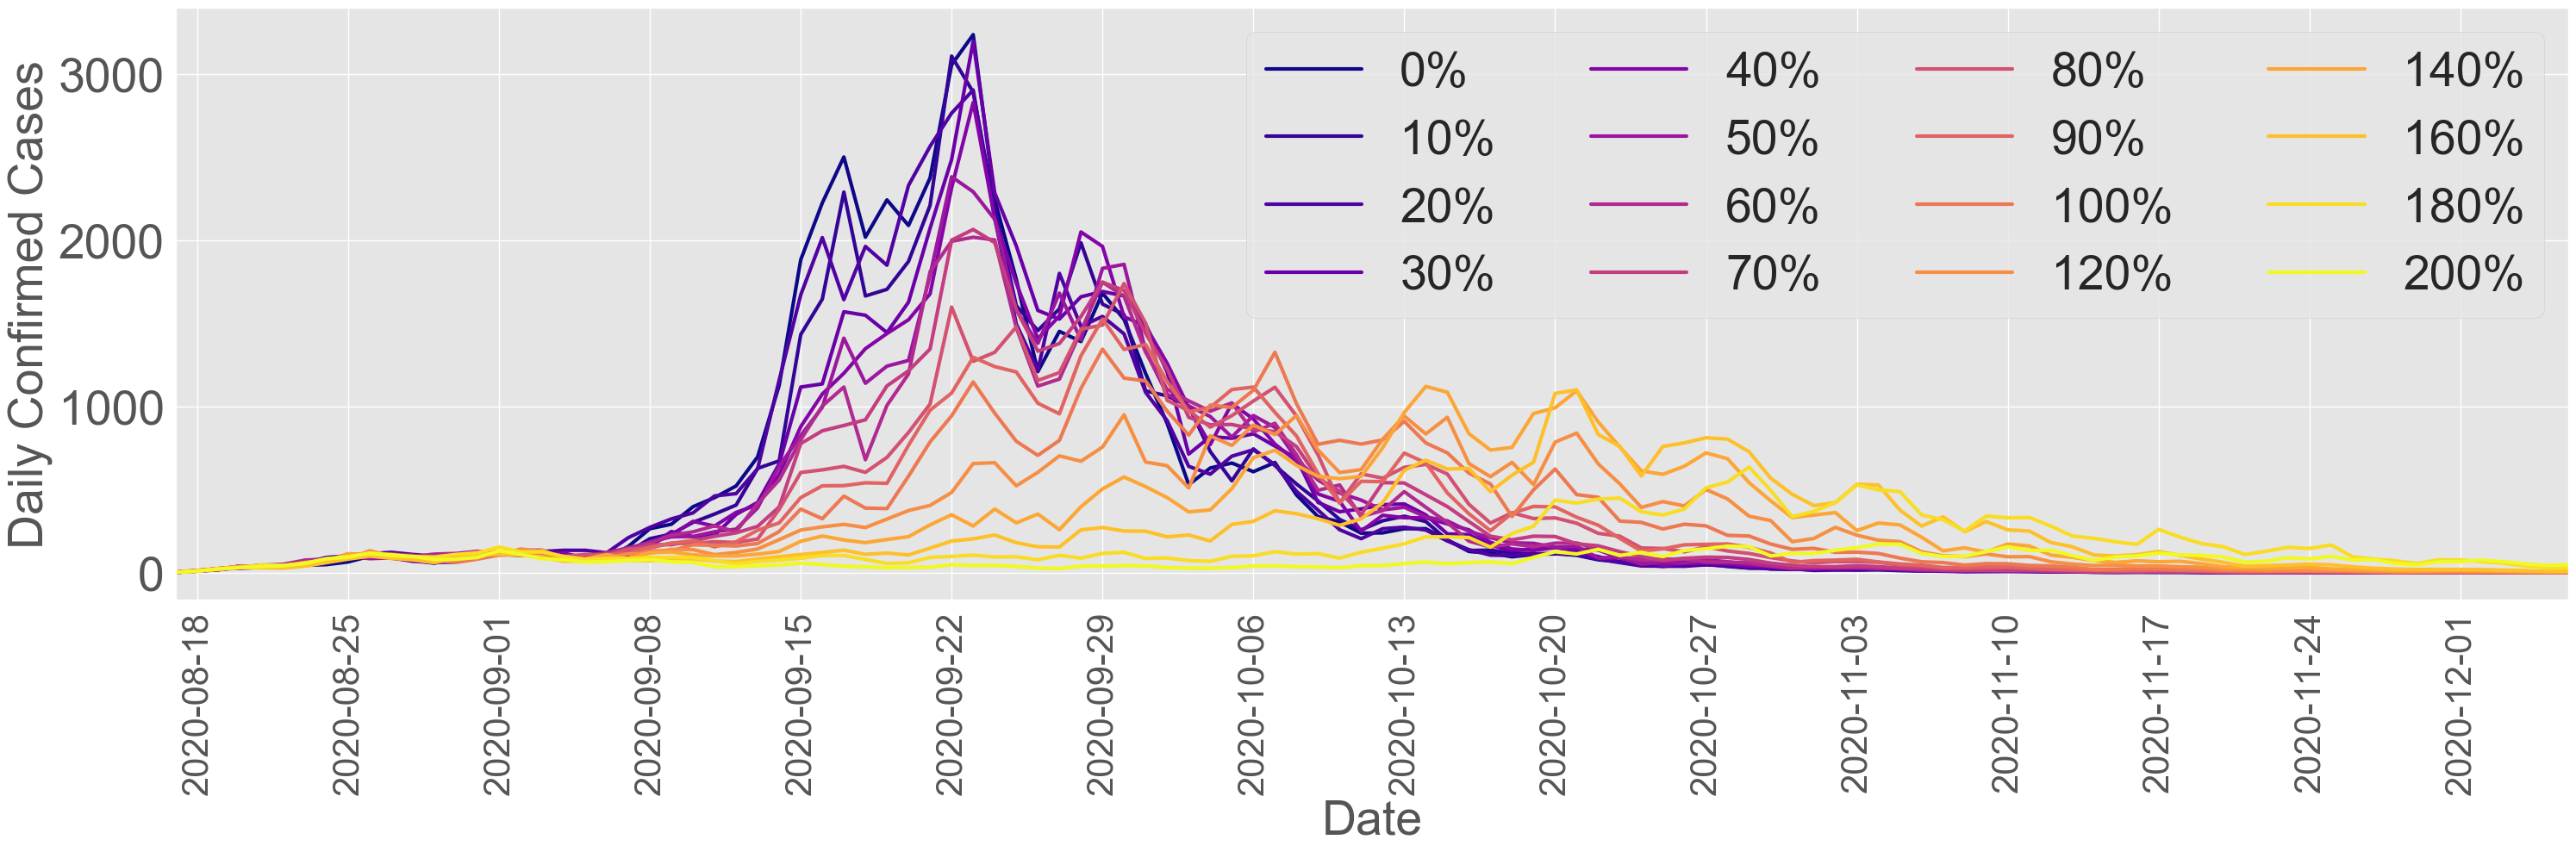

In [146]:
fig, ax = plt.subplots(figsize=(30,10))
#df_infection_data.plot(ax=ax, label='infected')
#df_infection_data_no_total.plot(ax=ax, label='infected_w/o')
#confirmed_cases.plot(ax=ax, label='confirmed')
confirmed_cases_no_total.plot(ax=ax, label='confirmed_w/o',linewidth=3, cmap = "plasma")

ax.set_ylabel("Daily Confirmed Cases")
ax.xaxis.set_major_locator(mdates.WeekdayLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.tick_params(axis='x', rotation=90)
ax.tick_params(axis='x', rotation=90)
plt.xticks(fontsize = 30)
plt.yticks(fontsize = 40)
#ax.set_title('Daily Confirmed Cases at UIUC with Different Testing Rates', fontsize = 30)
ax.set_ylabel('Daily Confirmed Cases')
ax.set_xlabel('Date')
ax.xaxis.label.set_size(40)
ax.yaxis.label.set_size(40)
ax.legend(ncol=4, prop={'size':40})
plt.show()

In [147]:
# compute cumulative confirmed cases
df_infection_data_no_cumul=pd.Series.cumsum(df_infection_data_no_total)
confirmed_cases_no_cumul=pd.Series.cumsum(confirmed_cases_no_total)

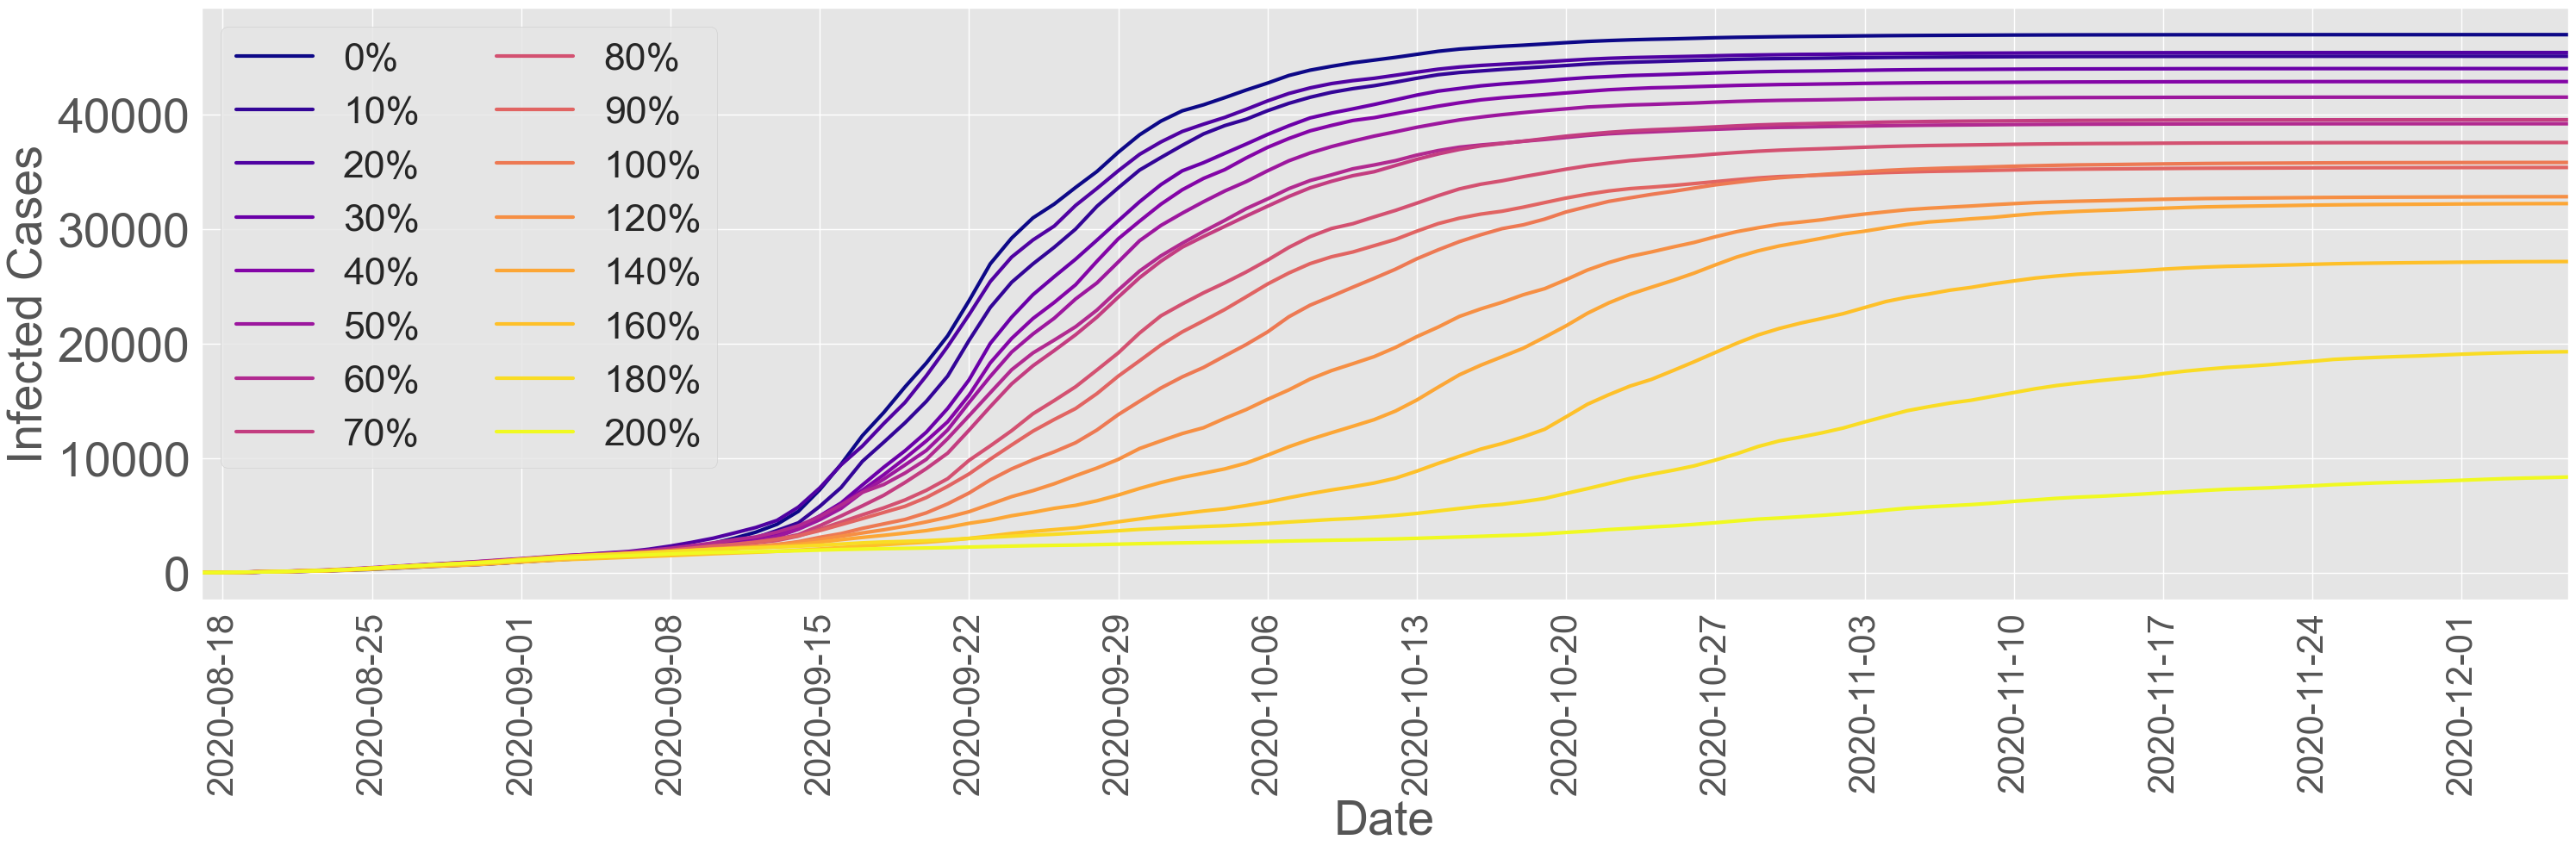

In [148]:
plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(30,10))
#df_infection_data.plot(ax=ax, label='infected')
#df_infection_data_no_total.plot(ax=ax, label='infected_w/o')
#confirmed_cases.plot(ax=ax, label='confirmed')
confirmed_cases_no_cumul.plot(ax=ax, label='confirmed_w/o',linewidth=3, cmap = "plasma")
ax.set_ylabel("Daily infections and confirmed cases")
ax.xaxis.set_major_locator(mdates.WeekdayLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.tick_params(axis='x', rotation=90)
plt.xticks(fontsize = 30)
plt.yticks(fontsize = 40)
#ax.set_title('Infected Cases at UIUC with Different Testing Rates (Mixed Symptomatic and Asymptomatic Infection)', fontsize = 15)
ax.set_ylabel('Infected Cases')
ax.set_xlabel('Date')
ax.xaxis.label.set_size(40)
ax.yaxis.label.set_size(40)
ax.legend(ncol = 2, prop={'size':32})
plt.show()

In [149]:
# Set ups for ploting heat map
# Define the function to change date format

from collections.abc import Iterable
from sklearn import linear_model

class AxTransformer:
    def __init__(self, datetime_vals=False):
        self.datetime_vals = datetime_vals
        self.lr = linear_model.LinearRegression()
        
        return
    
    def process_tick_vals(self, tick_vals):
        if not isinstance(tick_vals, Iterable) or isinstance(tick_vals, str):
            tick_vals = [tick_vals]
            
        if self.datetime_vals == True:
            tick_vals = pd.to_datetime(tick_vals).astype('int64').values

        tick_vals = np.array(tick_vals)
            
        return tick_vals
    
    def fit(self, ax, axis='x'):
        axis = getattr(ax, f'get_{axis}axis')()
        
        tick_locs = axis.get_ticklocs()
        tick_vals = self.process_tick_vals([label._text for label in axis.get_ticklabels()])
        
        self.lr.fit(tick_vals.reshape(-1, 1), tick_locs)
        
        return
    
    def transform(self, tick_vals):        
        tick_vals = self.process_tick_vals(tick_vals)
        tick_locs = self.lr.predict(np.array(tick_vals).reshape(-1, 1))
        
        return tick_locs
    
def set_date_ticks(ax, start_date, end_date, axis='x', date_format='%Y-%m-%d', **date_range_kwargs):
    dt_rng = pd.date_range(start_date, end_date, **date_range_kwargs)

    ax_transformer = AxTransformer(datetime_vals=True)
    ax_transformer.fit(ax, axis=axis)
    
    getattr(ax, f'set_{axis}ticks')(ax_transformer.transform(dt_rng))
    getattr(ax, f'set_{axis}ticklabels')(dt_rng.strftime(date_format))

    ax.tick_params(axis=axis, which='both', bottom=True, top=False, labelbottom=True)
    
    return ax

In [150]:
confirmed_cases_no_cumul = confirmed_cases_no_cumul.transpose()

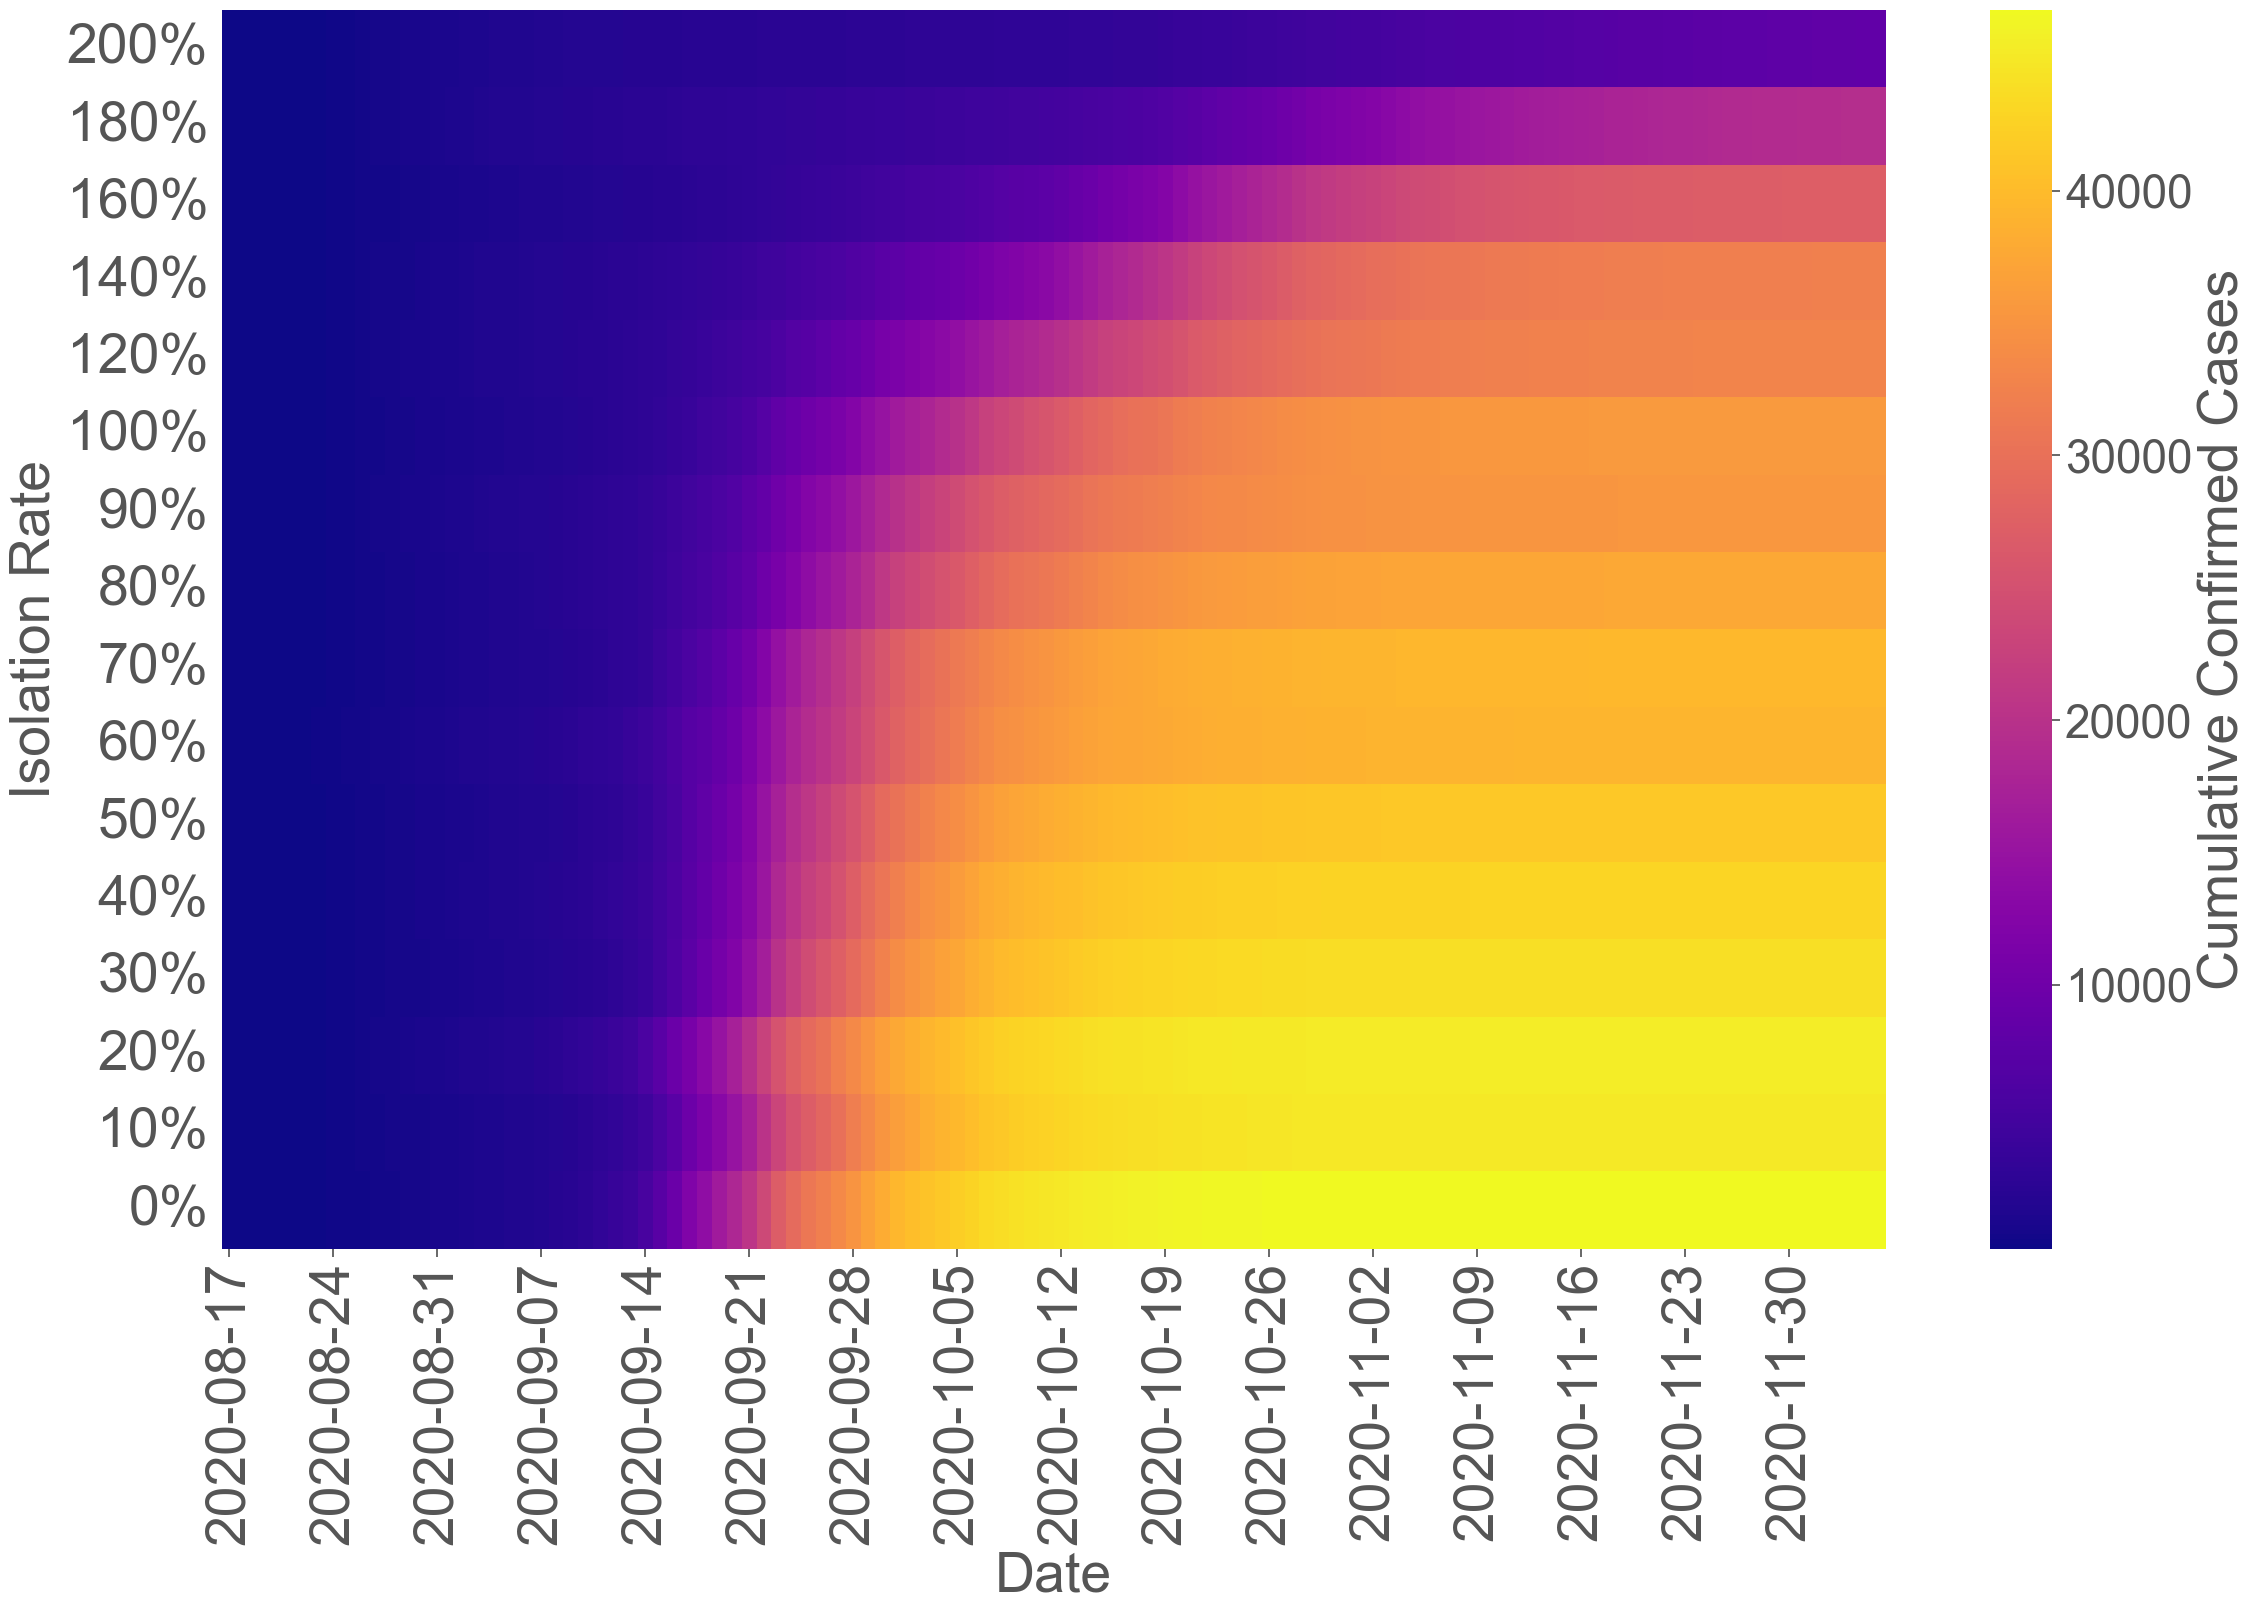

In [151]:
fig, ax1= plt.subplots(figsize=(24, 17))
sns.heatmap(confirmed_cases_no_cumul, cmap="plasma", robust=True, ax=ax1,cbar_kws={'label': 'Cumulative Confirmed Cases'})
sns.set(font_scale=3)
ax1.figure.axes[-1].yaxis.label.set_size(40)
ax1.set_ylabel("Isolation Rate", rotation=90)
plt.xticks(fontsize = 40)
#ax1.tick_params(axis='x', rotation=45)
plt.yticks(fontsize = 40)
#ax1.set_title('Cumulated Infected Cases at UIUC', fontsize = 40)
ax1.set_xlabel('Date')
ax1.xaxis.label.set_size(40)
ax1.tick_params(axis='y', rotation=360)                         
ax1.yaxis.label.set_size(40)
set_date_ticks(ax1, '2020-08-17', '2020-12-05', freq='7D')
ax1.invert_yaxis()
#ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.show()

In [152]:
confirmed_cases_no_total = confirmed_cases_no_total.transpose()

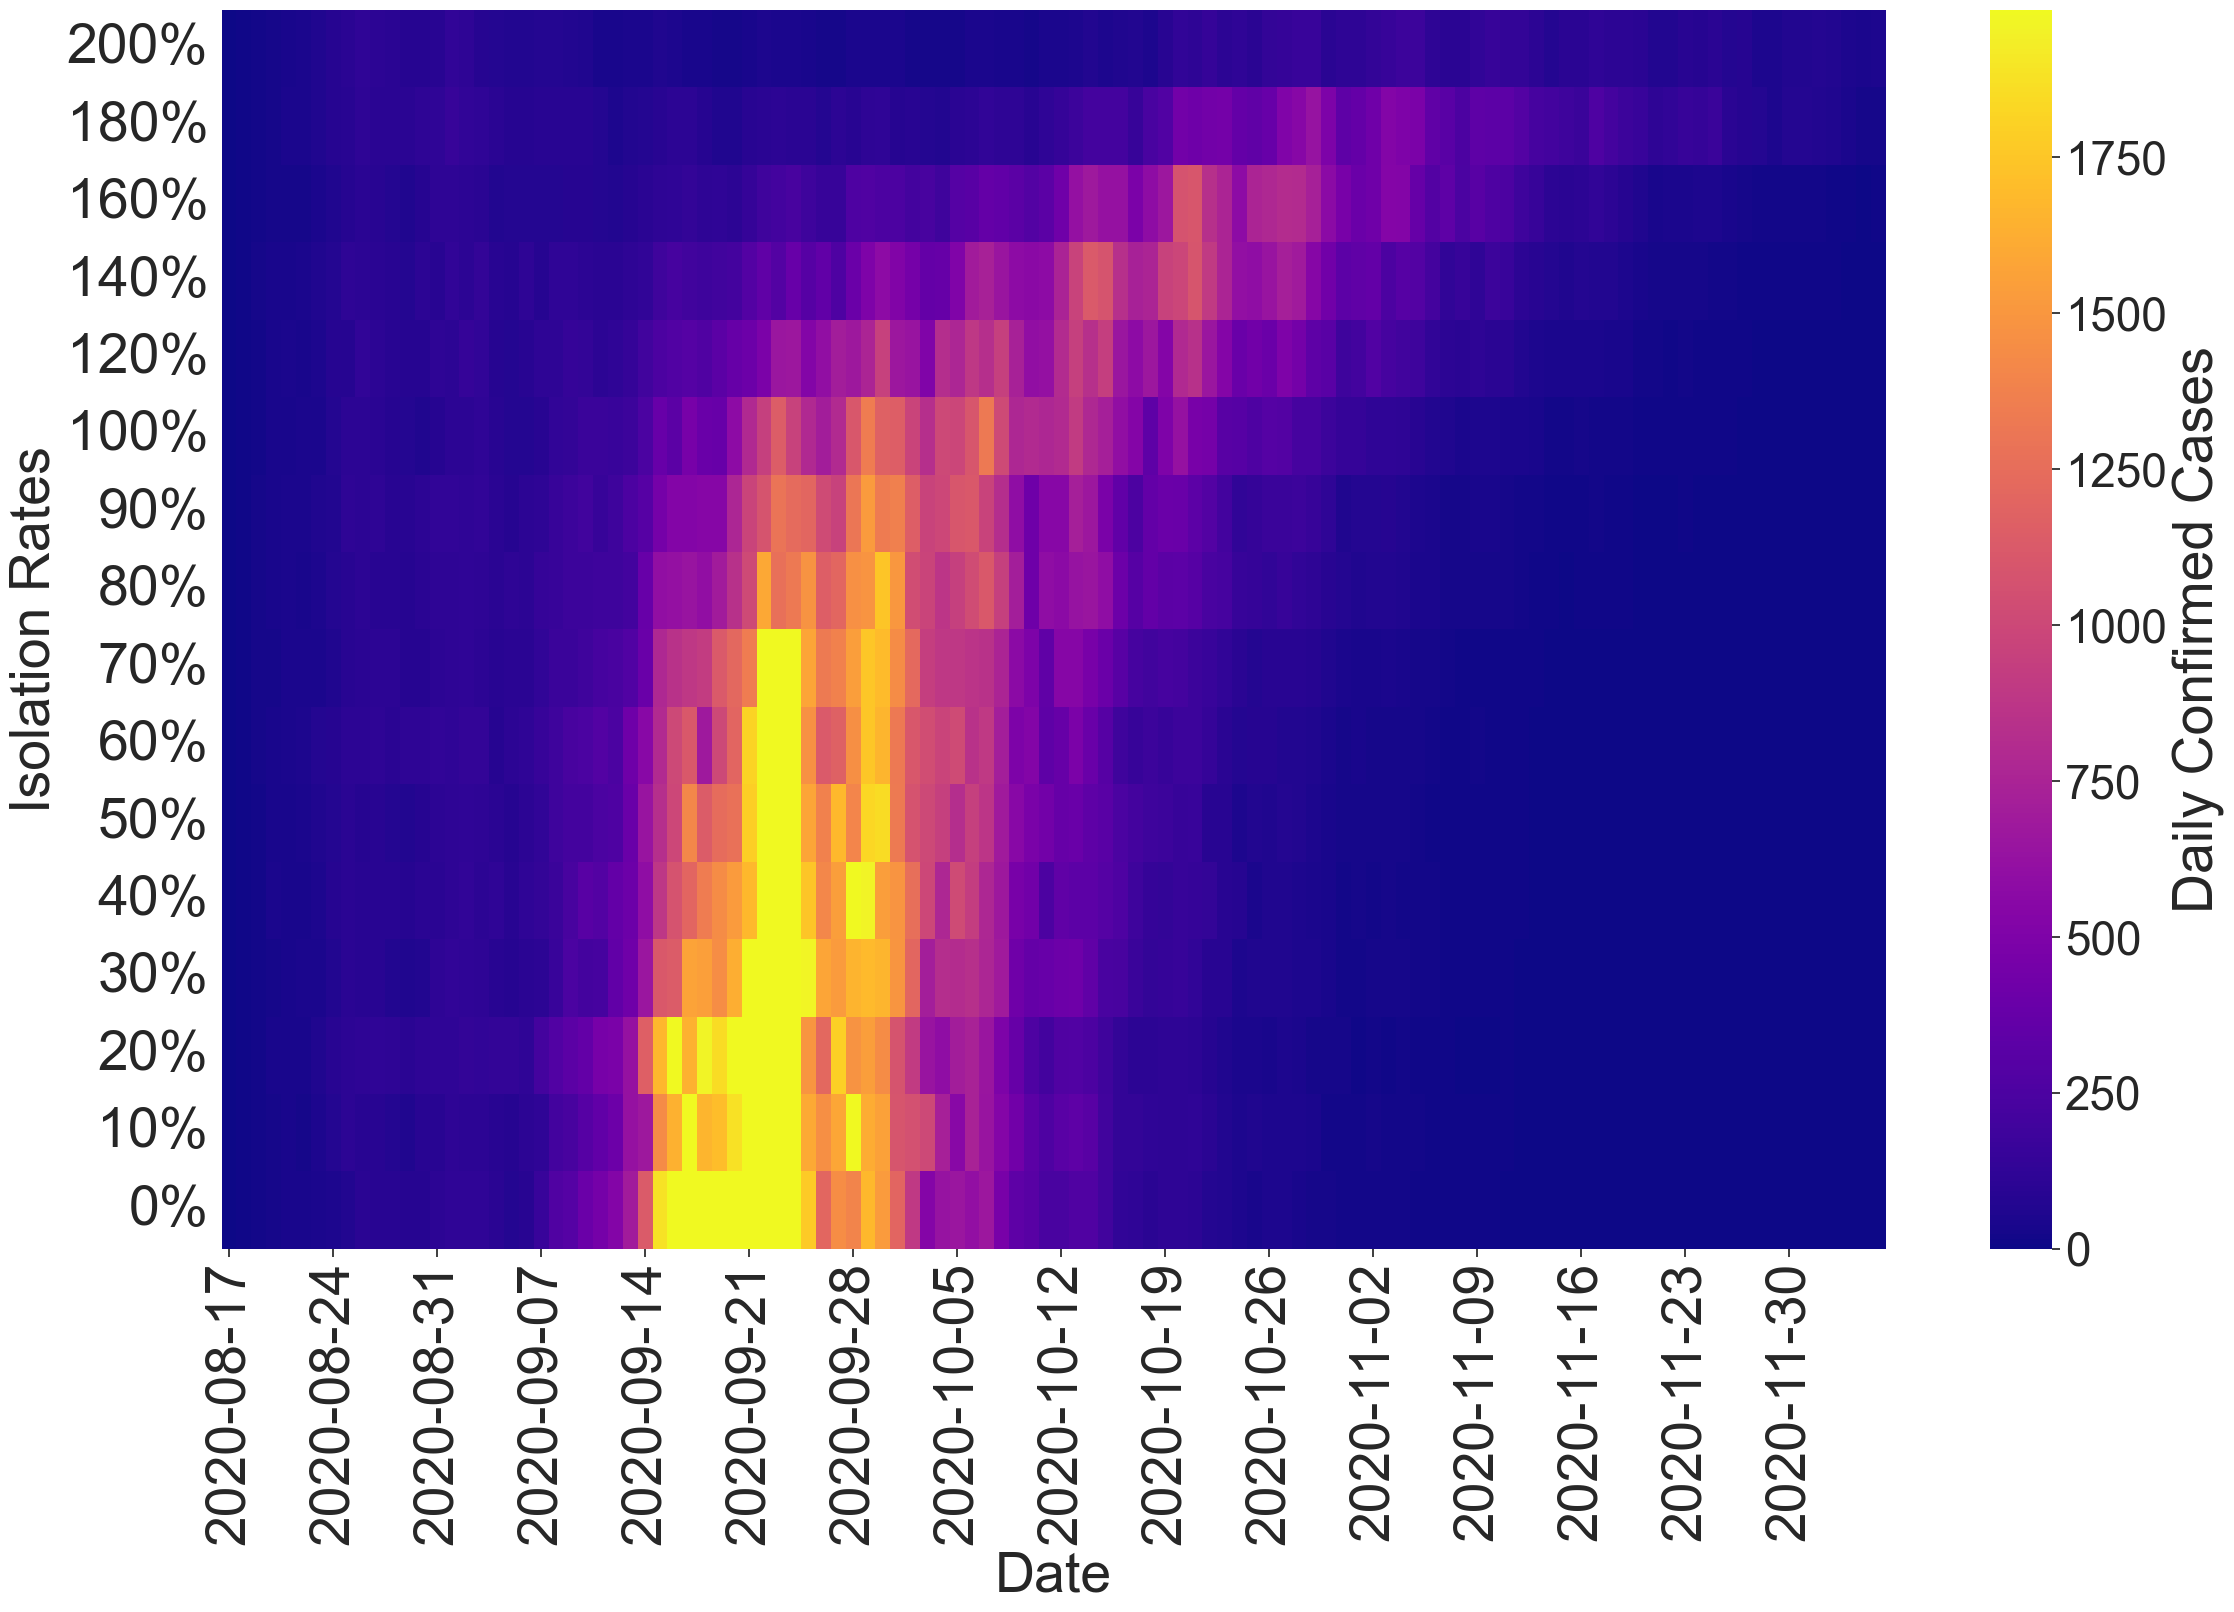

In [153]:
fig, ax1= plt.subplots(figsize=(24, 17))
sns.heatmap(confirmed_cases_no_total, cmap="plasma", robust=True, ax=ax1,cbar_kws={'label': 'Daily Confirmed Cases'})
ax1.set_xlabel("Date")
ax1.figure.axes[-1].yaxis.label.set_size(40)
#ax1.xaxis.set_major_locator(mdates.WeekdayLocator())
#ax1.yaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.xticks(fontsize = 40)
plt.yticks(fontsize = 40)
#ax1.set_title('Daily Confirmed Cases at UIUC with Different Testing Rates', fontsize = 30)
ax1.set_ylabel('Isolation Rates')
ax1.xaxis.label.set_size(40)
ax1.yaxis.label.set_size(40)
ax1.invert_yaxis()
ax1.tick_params(axis='x', rotation=90) 
set_date_ticks(ax1, '2020-08-17', '2020-12-05', freq='7D')
plt.show()

In [154]:
# Closed-loop feedback control framework

In [155]:

base_t = 2 # testing percentage for initial settings (0.55 testing rate or 0.55 symptomatic cases if we don't test)
window_t = 7 # testing window size
base_test = 1-base_t/window_t

serial_UIUC_New = functions._infection_update(testing_rate = 1-base_t/window_t, serial_interval = serial_UIUC)
serial_test = serial_UIUC_New/sum(serial_UIUC_New)
Scalor_New = sum(serial_UIUC_New)/sum(serial_UIUC)
print (Scalor)

#print (serial_test)
# change infection profile to serial interval
serial_UIUC_U=serial_UIUC_New / sum(serial_UIUC_New)
#Important 
Scalor_Rel= Scalor/Scalor_New

0.3888463152640313


In [156]:
serial_UIUC_U = np.delete(serial_UIUC_U,[0])

In [157]:
#Compute how much infection we have last week
#Put the control update out of the loop
# Construct the loops_Adding Control Strategies
# Consider no delays

# Targeted effective reproduction number
Target_R_t = 0.90

N_Data_Len = 120
true_r = uiuc_r_fall                                                  # Assign true reproduction numbers, estimated from UIUC's data
seed_update = [40, 50, 80, 40, 86, 82, 143, 148, 164,88]              # Initial Conditions; Update recursively
seed_update_no = [40, 50, 80, 40, 86, 82, 143, 148, 164,88]
# Define a function of generating synthetic data

# Run the simulation
# Updating frequency

Frequency=14
Update_Frequency = list(range(0, N_Data_Len+Frequency, Frequency)); #construct time-window

#initiate the simulation for the first round 
incidence_ts = functions._synthetic_infections_U(
    seed=seed_update, r_ts=true_r[0:Frequency], SI_interval = serial_UIUC_U
)

# first round simulated data incidence_ts

infection_mid = incidence_ts.tolist() #convert pd.series to list
infection_data = infection_mid        #pass data 
seed_update = infection_data[-len(serial_UIUC_U):]  #update initial conditions


# first round simulated data incidence_ts_no

incidence_ts_no = functions._synthetic_infections_U(
        #seed=[26, 21, 30, 56, 57,44, 53, 83, 89, 54, 47, 63, 49, 104, 231, 197,120, 87], r_ts=true_r
        # seed=[26, 21, 30, 56, 57,44, 53, 83, 231, 197,120] (important, to generate the same infection trend as UIUC)
    seed=seed_update_no, r_ts=true_r[0:Frequency], SI_interval= serial_UIUC_U
)


infection_mid_no= incidence_ts_no.tolist() #convert pd.series to list
infection_data_no= infection_mid_no     #pass data 
seed_update_no= infection_data_no[-len(serial_UIUC_U):]  #update initial conditions

total_I_No_T = sum(infection_data_no)
seed_update_no=infection_data_no[-len(serial_UIUC_U):]
total_I_No_T_Update = sum(infection_data)
total_I_now_Update= sum(infection_data_no)
Multiplier=Scalor #later stage, change it when changing control input; now it is a constant
Total_pop = 50000

#update Scalor_Rel
# change the testing rate from 1/7 to 0.5/7; 0.3/7; 0.1/7; 0.05/7; Then we can do adaptive testing
# Constructing infection profile under_baseline testing rate
serial_UIUC_New = functions._infection_update(testing_rate = 1-2/7, serial_interval = serial_UIUC)
serial_test = serial_UIUC_New/sum(serial_UIUC_New)
Scalor_New = sum(serial_UIUC_New)/sum(serial_UIUC)


#print (serial_test)
# change infection profile to serial interval
serial_UIUC_U=serial_UIUC_New / sum(serial_UIUC_New)
serial_UIUC_U = np.delete(serial_UIUC_U,[0])
#Important 

Scalor_Rel= Scalor/Scalor_New

Rt_Inter= true_r[1]*Scalor_Rel
Rt_Final = Rt_Inter
Rt_updated = Rt_Inter
#Testing_base 

# fisrt week rate
testing_rate_first_week = 0.5

testing_rate = 1-testing_rate_first_week/7 # first week testing rate ! Important ! can adjust 
Testing_base = np.ones(Frequency) * (1-testing_rate)*7

# ===============================================================================================
# reset infection profiles

# ===============================================================================================

for i in Update_Frequency[2::]:
    
    # 1. Simulating UIUC spreading Processes with testing strategies (leveraging data we have)
    incidence_ts = functions._synthetic_infections_U(
        seed=seed_update, r_ts=true_r[i+1-Frequency:i], SI_interval= serial_UIUC_U
    ) 
    infection_mid = incidence_ts.tolist() #convert pd.series to list
    infection_data.extend(infection_mid)
    seed_update = infection_mid[-len(serial_UIUC_U):]
    
    # 2. Simulating UIUC spreading Processes with adaptive testing strategies
    
    
    infection_data_pass=infection_data
    total_I_now = sum(infection_data_pass)
    
    incidence_ts_no, Rt_updated = functions._synthetic_infections_Adaptive(
        seed=seed_update_no, r_ts=true_r[i+1-Frequency:i],serial_UIUC_U= serial_UIUC_U,total_I_No_T=total_I_No_T_Update,total_I_now=sum(infection_data_pass),Total_pop=50000, Multiplier=Scalor_Rel, Rt_updated=Rt_updated
    ) # By setting Scalor = 1, we can adjust serial interval and control system input in the function;
    
    infection_mid_no = incidence_ts_no.tolist() #convert pd.series to list
    infection_data_no.extend(infection_mid_no)
    seed_update_no= infection_mid_no[-len(serial_UIUC_U):]
    
    total_I_No_T_Update = sum(infection_data_no)
    #Rt_Final = np.append(Rt_Final,Rt_Inter[2::])
    #attaching updated R
    if i>len(R_direct):
        break
    if  sum(R_direct[i-14:i])/len(R_direct[i-14:i])>1:#in reality, we need to consider the proportion of the data we have/ the ported cases will be different.
        print(sum(R_direct[i-14:i])/len(R_direct[i-14:i]))
        #const_factor = sum(serial_UIUC_O)*Scalor/(sum(true_r[-14:-1])/len(true_r[-14:-1]))
        
        const_factor = sum(R_direct[i-14:i])/len(R_direct[i-14:i])
        #print(const_factor)
        my_array = serial_UIUC[2::]/sum(serial_UIUC[2::])*const_factor
        my_array[:] = my_array[::-1]
        #my_array = my_array* sum(Rt_updated[-14:-1])/len(Rt_updated[-14:-1])
        my_array = np.append (my_array,-Target_R_t) # expected reproduction number !
        #print(const_factor)
        solution = np.roots(my_array) 
            
        solution = solution.real[abs(solution.imag)<1e-10]
    
        solution = solution.real[solution.real>0]
        solution = solution.real[solution.real<1]
        print(solution)  
        if solution.size == 0 or solution<0:
                solution=1-2/7
        Testing_base = np.append(Testing_base, (np.ones(Frequency) * (1-solution)*7)) 
        
        serial_UIUC_New = functions._infection_update(testing_rate = solution, serial_interval = serial_UIUC)
        serial_test = serial_UIUC_New/sum(serial_UIUC_New)
        Scalor_New = sum(serial_UIUC_New)/sum(serial_UIUC)
        serial_UIUC_U=serial_UIUC_New / sum(serial_UIUC_New)
        Scalor_Rel= Scalor/Scalor_New
        serial_UIUC_U = np.delete(serial_UIUC_U,[0])
        
    
    
    #============================================add delay for data with testing===========================================================

    # output synthetic data: infection_data

    df_infection_data = pd.DataFrame (infection_data, columns = [''])    #convert list into dataframe
    df_infection_data= df_infection_data.squeeze() #convert  dataframe into data.series

    # from infected cases to confirmed cases

    col = delay_distrb[:len(df_infection_data)]
    row = np.concatenate(([delay_distrb[0]], np.zeros(len(df_infection_data)-1)), axis=None)
    delay_kernel = la.toeplitz(col, row)
        


    #compute confirmed cases

    confirmed_expected = delay_kernel @ df_infection_data
    confirmed_noise = np.random.normal(0, 1, size=len(df_infection_data))/10
    week_pattern = np.sin(2*np.pi*np.arange(len(df_infection_data))/7)/5
    
    confirmed_cases = pd.Series(confirmed_expected*(1 + confirmed_noise + week_pattern), index=df_infection_data.index).astype(int)
    
    #============================================add delay for data without testing===========================================================
     # output synthetic data: infection_data

    df_infection_data_no = pd.DataFrame (infection_data_no, columns = [''])    #convert list into dataframe
    df_infection_data_no= df_infection_data_no.squeeze() #convert  dataframe into data.series

    # from infected cases to confirmed cases

    col = delay_distrb[:len(df_infection_data)]
    row = np.concatenate(([delay_distrb[0]], np.zeros(len(df_infection_data)-1)), axis=None)
    delay_kernel = la.toeplitz(col, row)
        


    #compute confirmed cases

    confirmed_expected_no = delay_kernel @ df_infection_data_no
    confirmed_noise_no= np.random.normal(0, 1, size=len(df_infection_data_no))/10
    week_pattern_no= np.sin(2*np.pi*np.arange(len(df_infection_data_no))/7)/5
    
    confirmed_cases_no= pd.Series(confirmed_expected_no*(1 + confirmed_noise_no + week_pattern_no), index=df_infection_data_no.index).astype(int)
    
   


2.238821319499678
[0.72356601]
2.4899147863793316
[0.69413749]
2.669662910458205
[0.67520914]
3.1376849494488814
[0.63249828]
2.347983990630073
[0.71030299]
2.4849985237578673
[0.6946785]
2.201021625944954
[0.72834213]


In [158]:

const_factor = sum(R_direct[i-14:i])/len(R_direct[i-14:i])
        #print(const_factor)
my_array = serial_UIUC[2::]/sum(serial_UIUC[2::])*const_factor
my_array[:] = my_array[::-1]
my_array = np.append (my_array,1)
        #print(const_factor)
solution = np.roots(my_array) 

In [159]:
date_updated = pd.Series(pd.date_range("2020-08-17", freq="D", periods=len(confirmed_cases_no)))

In [160]:
Testing_base_U= np.append(Testing_base, Testing_base[-7:])
Testing_base_P = pd.Series(Testing_base_U) 

Testing_Fixed = np.ones(105)*2
Testing_Fixed_P = pd.Series(Testing_Fixed) 
Testing_Fixed_P = pd.concat([date_updated, Testing_Fixed_P], axis=1)
Testing_Fixed_P = Testing_Fixed_P.set_axis(['Date','Fixed Isolation Rate'], axis=1, copy=False)
Testing_Fixed_P =  Testing_Fixed_P.set_index('Date')

Testing_base = pd.Series(Testing_base) 
Testing_base = pd.Series(Testing_base) 
Testing_base = pd.concat([date_updated, Testing_base], axis=1)
Testing_base = Testing_base.set_axis(['Date','Adaptive Isolation Rate'], axis=1, copy=False)
Testing_base =  Testing_base.set_index('Date')

Testing_base= Testing_base[0:103]

In [161]:
# add delays, nosie, and weekly pattern
confirmed_cases_no = pd.concat([date_updated, confirmed_cases_no], axis=1)
#confirmed_cases_no_total = confirmed_cases_no_total.rename(columns={0: "Date", 1: "0%", 2: "10%", 3: "20%", 4: "30%", 5: "40%", 6: "50%", 7: "60%", 8: "70%", 9: "80%", 10: "90%", 11: "100%", 12: "110%",13: "120%", 14: "130%", 15: "140%",16: "150%"})
confirmed_cases_no = confirmed_cases_no.set_axis(['Date','Confirmed Cases (Adaptive Isolation Rate)'], axis=1, copy=False)
#confirmed_cases_no_total = confirmed_cases_no_total.set_axis(['Date','0%', '20%', '40%','60%', '80%', '100%', '120%', '160%','180%', '200%'], axis=1, inplace=False)
confirmed_cases_no =  confirmed_cases_no.set_index('Date')

confirmed_cases = pd.concat([date_updated, confirmed_cases], axis=1)
#confirmed_cases_no_total = confirmed_cases_no_total.rename(columns={0: "Date", 1: "0%", 2: "10%", 3: "20%", 4: "30%", 5: "40%", 6: "50%", 7: "60%", 8: "70%", 9: "80%", 10: "90%", 11: "100%", 12: "110%",13: "120%", 14: "130%", 15: "140%",16: "150%"})
confirmed_cases = confirmed_cases.set_axis(['Date','Confirmed Cases (Fixed Isolation Rate)'], axis=1, copy=False)
#confirmed_cases_no_total = confirmed_cases_no_total.set_axis(['Date','0%', '20%', '40%','60%', '80%', '100%', '120%', '160%','180%', '200%'], axis=1, inplace=False)
confirmed_cases =  confirmed_cases.set_index('Date')

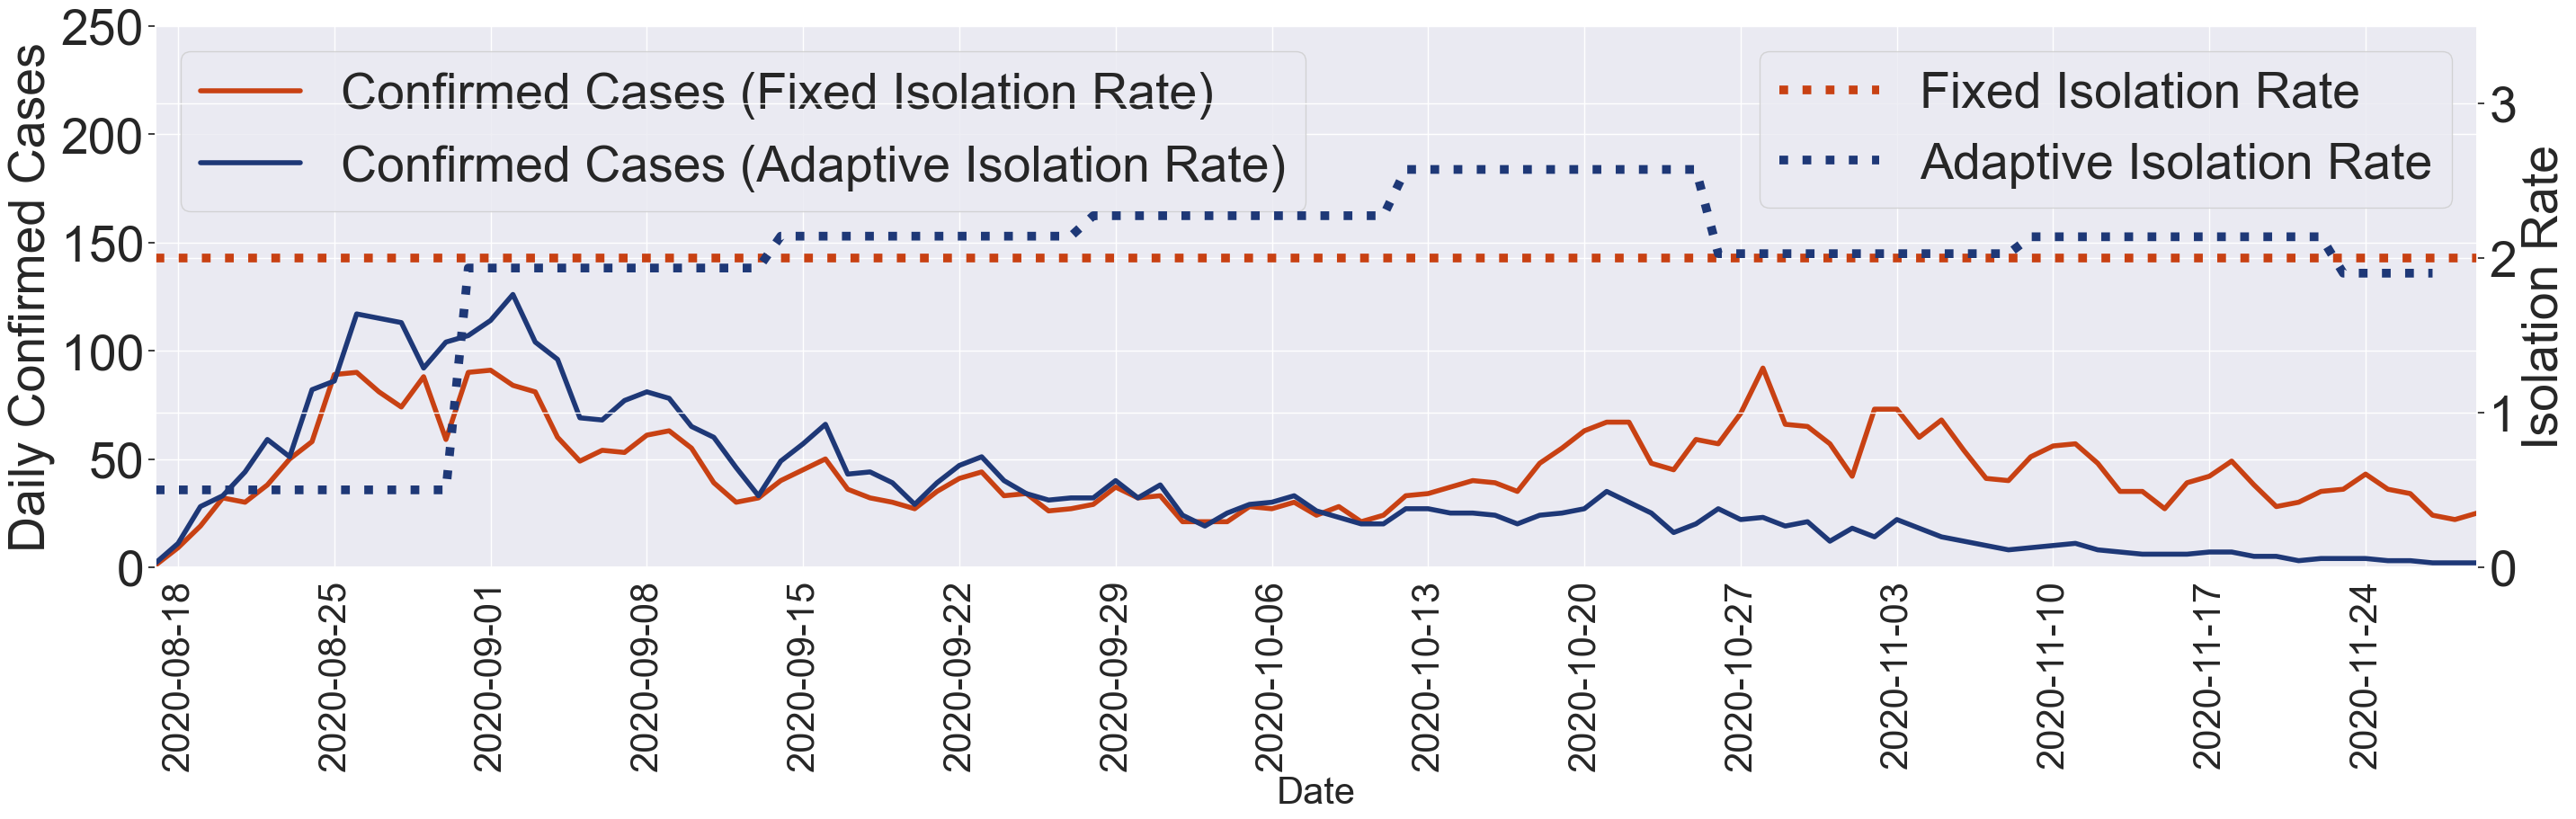

In [162]:
fig, ax = plt.subplots(figsize=(30, 10))
plt.yticks(fontsize=40)
plt.xticks(fontsize=30)
confirmed_cases.plot(ax=ax, label='Confirmed Cases (Fixed Isolation)',linewidth=4, color = '#C84113')
confirmed_cases_no.plot(ax=ax, label='Confirmed Cases (Adaptive Isolation)',linewidth=4, color = '#1E3877')
ax.xaxis.set_major_locator(mdates.WeekdayLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.set_xlabel("Date",fontsize = 40)
ax.legend(loc='upper left',fontsize = 40)
ax.set_ylabel("Daily Confirmed Cases",fontsize = 40)
plt.ylim((0,250))

ax1 = ax.twinx()
#df_infection_data.plot(ax=ax, label='infected')
#df_infection_data_no.plot(ax=ax, label='infected_w/o')
Testing_Fixed_P.plot(ax=ax1, label='Fixed Isolation Rate',linewidth=7,alpha=1,linestyle=':',color = '#C84113')
Testing_base.plot(ax=ax1, label='Adaptive Isolation Rate',linewidth=7,alpha=1,linestyle=':', color = '#1E3877')
ax1.xaxis.set_major_locator(mdates.WeekdayLocator())
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax1.set_ylabel("Isolation Rate",fontsize = 40)
ax1.legend(fontsize = 40)
plt.ylim((0,3.5))
plt.yticks(fontsize=40)
#ax.set_title('Confirmed Cases at UIUC with the Feedback Control Strategy', fontsize = 25)
ax.xaxis.label.set_size(30)
ax.yaxis.label.set_size(40)
ax.tick_params(axis='x', rotation=90)
plt.show()